# Results processing and analysis for Multivariate EE
---
Last Updated on 2-3-2022

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import glob
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML, Image, IFrame
import math
from scipy import stats
import random
import statsmodels.api as sm
from colorama import init
# init()
from termcolor import colored, cprint

%matplotlib inline

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option("display.max_seq_items", 200)

# Utility Functions
---

### Load dataset information and published results
from www.timeseriesclassification.com

In [59]:
print(os.path.abspath("/data"))
uae_mts_archive = pd.read_csv('/data/mUAE2018.csv')
uae_mts_archive = uae_mts_archive[['dataset', 'trainsize', 'testsize', 'dimensions', 'length', 'classes']]

uae_mts_results = pd.read_csv('/data/mUAE2018-results.csv')
uae_mts_results = uae_mts_archive.merge(uae_mts_results, on='dataset')

display(uae_mts_archive.head())
display(uae_mts_results.head())
# print(muae['dimensions'].value_counts())
# uae_mts_results['dimensions'].hist(bins=100)

E:\data


,dataset,trainsize,testsize,dimensions,length,classes
0,ArticularyWordRecognition,275,300,9,144,25
1,AtrialFibrillation,15,15,2,640,3
2,BasicMotions,40,40,6,100,4
3,CharacterTrajectories,1422,1436,3,182,20
4,Cricket,108,72,6,1197,12


,dataset,trainsize,testsize,dimensions,length,classes,EUCI-norm,DTWI-norm,DTWD-norm,EUCI+norm,DTWI+norm,DTWD+norm
0,ArticularyWordRecognition,275,300,9,144,25,0.9700,0.9800,0.9870,0.9700,0.9800,0.9870
1,AtrialFibrillation,15,15,2,640,3,0.2670,0.2670,0.2000,0.2670,0.2670,0.2200
2,BasicMotions,40,40,6,100,4,0.6750,1.0000,0.9750,0.6760,1.0000,0.9750
3,CharacterTrajectories,1422,1436,3,182,20,0.9640,0.9690,0.9900,0.9640,0.9690,0.9890
4,Cricket,108,72,6,1197,12,0.9440,0.9860,1.0000,0.9440,0.9860,1.0000


### Other utility functions

In [60]:
def get_datasets_in_path(path, exclude="."):
    '''
    Get a list of datasets in the fiven folder based on subdir names

    :param path:
    :param exclude:
    :return:
    :version: 28-2-2022
    :author: shifaz
    '''
    datasets = [os.path.basename(os.path.dirname(p)) for p in glob.glob(path + "*/") if not os.path.basename(os.path.dirname(p)).startswith(exclude) ]
    return datasets

datasets = "ERing,BasicMotions,Libras,RacketSports,AtrialFibrillation,NATOPS,Handwriting,Epilepsy,\
            UWaveGestureLibrary,FingerMovements,ArticularyWordRecognition,HandMovementDirection,\
            LSST,StandWalkJump,Cricket,SelfRegulationSCP1,SelfRegulationSCP2,EthanolConcentration,\
            Heartbeat,DuckDuckGeese,PenDigits,PhonemeSpectra,PEMS-SF,MotorImagery,FaceDetection,EigenWorms".split(",")

# get_datasets_in_path("E:/git/experiments/knn/20-10-2020/sorted/")


In [61]:
def concatenate_dataframes(file_list, sort = False, reset_index = True, drop_index = False, index_col = 0):
    '''
        Reads multiple dataframes from the given file list and concatenates them
        :version: 3-3-2022
        :author: shifaz
    '''
    df_list = []
    for file in file_list:
        df_tmp = pd.read_csv(file, index_col = index_col)
        df_list.append(df_tmp)
    df_combined = pd.concat(df_list, sort = sort)
    if reset_index:
        df_combined = df_combined.reset_index(drop = drop_index)
    return df_combined


In [62]:
def process_files(src_dir, dest_dir, datasets, operation = "copy", dry = True, file_pattern = ".csv", old_name = None, new_name = None):
    import os
    from shutil import copyfile
    
    for dataset in datasets:
        print(f"{dataset} : DRY = {dry} ".ljust(80, '-'))
        src_pattern = f"{src_dir}/{dataset}/{dataset}{file_pattern}"
        files = glob.glob(src_pattern)
        print(f"{operation}: {len(files)} files ({src_pattern}) \n from {src_dir}/{dataset}\n to {dest_dir}/{dataset}")           

        for i, src_filename in enumerate(files):
            src_path, src_basename = os.path.split(src_filename)
            dest_filename = f"{dest_dir}/{dataset}/{src_basename}"
            dest_path, dest_basename = os.path.split(dest_filename)
            print(f"\t{i}.{operation.upper()}: {src_basename}")
            
            try:           
                if operation == "copy":
                    print(f"\t  COPIED: {dest_basename}")
                    if not dry:
                        os.makedirs(dest_path, exist_ok=True)                        
                        copyfile(src_filename, dest_filename)
                elif operation == "rename" and old_name != None and new_name != None:
                    new_filename = src_filename.replace(old_name, new_name)
                    new_path, new_basename = os.path.split(new_filename)
                    print(f"\t  RENAMED: {src_basename} to {new_basename}")
                    if not dry:
                        os.rename(src_filename, new_filename)
                elif operation == "move":
                    print(f"\t  MOVED: {src_basename}")
                    if not dry:
                        os.makedirs(dest_path, exist_ok=True)
                        copyfile(src_filename, dest_filename)
                        os.remove(src_filename)
                elif operation == "delete":
                    print(f"\t  DELETED: {src_basename}")
                    if not dry:
                        os.remove(src_filename)
                else:
                    raise Exception("Unknown operation")
            except Exception as e:
                print(f"ERROR {operation} - {src_basename}: {e}")                    

    
# config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/test/"

# datasets = ['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 
#             'Epilepsy', 'ERing', 
#             'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'Libras', 
#             'LSST', 'NATOPS', 'RacketSports', 'UWaveGestureLibrary']

# datasets = ['ERing']
datasets = get_datasets_in_path(prod_indir)

src_dir = "E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2+norm/test/"
dest_dir = "E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2+norm/test/"
datasets = get_datasets_in_path(prod_indir)

# process_files(src_dir, dest_dir, datasets, operation = "rename", dry = True, file_pattern="*.train.best.csv", old_name = '.train.best.csv', new_name = '.train.best.exp.csv')

# process_files(src_dir, dest_dir, datasets, operation = "copy", dry = False, file_pattern="*.train.best.*.csv", old_name = '.train.best.csv', new_name = '.train.best.exp.csv')
# process_files(src_dir, dest_dir, datasets, operation = "copy", dry = False, file_pattern="*.train.all.csv", old_name = '.train.best.csv', new_name = '.train.best.exp.csv')
# process_files(src_dir, dest_dir, datasets, operation = "rename", dry = False, file_pattern="*-norm.train.all.csv", old_name = '-norm.train.all.csv', new_name = '.delete.csv')


In [63]:
# function to check completed experiments

def check_completion(input_dir, datasets, 
                     measures = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr',
                     'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe'],
                     dependency=[True, False], 
                     verify_extra_data = False,
                     mem=500,
                     time=24,
                     job=None,
                     outdir="m3-2010-test",
                     pindep=2,
                     pdep=2,
                     folds=list(range(0,10)),
                     norm=True,
                     verbosity=0):
    from warnings import warn

    print(f"Searching: {input_dir}")
    i = 1
    for dataset in datasets:
        for fold in folds:
            print(f"{i}.{dataset}.fold{fold}:")

            search_pattern = f"{input_dir}/fold{fold}/{dataset}/{dataset}*.train.exp.csv"
            exp_files = glob.glob(search_pattern)

            if verbosity >= 0:
                print(f"{i}.{dataset}-fold{fold}: {len(exp_files)} exp files found")
            if verbosity > 3:
                print(f"  {dataset}-fold{fold}: {len(exp_files)} exp files found, searched: ({search_pattern})")

            try:
                tmp = []
                for file in exp_files:
                    # print(file)
                    tmp.append(pd.read_csv(file, index_col=False))
                df_all = pd.concat(tmp)
    #             print(df_all.shape)
            except Exception as e:
                print(f"ERROR {file}\n:{e}")
    #         display(df_all.head())

            j = 1
            for m in measures:
                for d in dependency:
                    filtered_df = df_all[(df_all['useDependentDims'] == d) & (df_all['name'] == m)]
                    num_params = filtered_df['paramID'].unique()

                    if norm:
                        nn = "+n"
                    else:
                        nn = "-n"

                    job = f"{dataset[:2].upper()}{m[0:2].lower()}-i{pindep}d{pdep}{nn}"

                    slurm_template = f"python3 launcher.py -j={job} -mem={mem} -time={time}:00:00 -o=m3-2010b-i{pindep}d{pdep}{nn} -norm={str(norm).lower()} -pi={pindep} -pd={pdep} -dp={str(d).lower()} -p=100:0,100,1 -m={m} -d={dataset}"

                    if m in ['euc', 'dtwf', 'ddtwf'] and len(num_params) != 1:
                        if verbosity > 1:
                            print(f"  {j}.WARN:{dataset} {len(num_params)}/1 paramID was found for: {m}, dep: {d}")
                        if verbosity > 0 or verbosity == -1:
                            print(f"    {slurm_template}")
                    elif m not in ['euc', 'dtwf', 'ddtwf'] and len(num_params) != 100:
                        if verbosity > 1:
                            print(f"  {j}.WARN:{dataset} {len(num_params)}/100 paramID for: {m}, dep: {d}")
                        if verbosity > 0 or verbosity == -1:
                            print(f"    {slurm_template}")
                    else:
                        if verbosity > 2:
                            print(f"  {j}.FOUND: {dataset} {len(num_params)}/100 paramID for: {m}, dep: {d}")
                    j = j + 1
            i = i + 1


            if verify_extra_data:
                pass
                # check norm, pi, di


    #         path, basename = os.path.split(file)
    #         print(basename)

    #         expfile = file
    #         queryfile = file.replace(".exp.csv", ".query.csv")
    #         countfile = file.replace(".exp.csv", ".count.csv")

    #         df_exp = pd.read_csv(expfile, index_col=False)
    #         df_query = pd.read_csv(queryfile, index_col=False)
    #         df_count = pd.read_csv(countfile, index_col=False)

#         display(df_exp.head())

        
        
        
prod_dir = "E:/git/experiments/knn/20-10-2020/sorted/"
prod_dir = "E:/git/experiments/knn/10-2-2022/m3/"
datasets = get_datasets_in_path(f"{prod_dir}i1d2+norm/train/")

prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
datasets = get_datasets_in_path(f"{prod_indir}/fold0/")

# datasets = ['PhonemeSpectra', 'ERing']

# check_completion(input_dir = f"{prod_indir}/", datasets = datasets,verify_extra_data=False, verbosity=2,
#                  mem=500, time=24, job=None, outdir="m3-2010-test",
#                  norm=True, pindep=2, pdep=2, dependency=[False,True])

# check_completion(input_dir = f"{prod_dir}i2d2+norm/train/", datasets = datasets,verify_extra_data=False, verbosity=3,
#                  mem=500, time=24, job=None, outdir="m3-2010-test",
#                  norm=True, pindep=2, pdep=2, dependency=[False,True])

# check_completion(input_dir = f"{prod_dir}i2d2+norm/train/", datasets = datasets,verify_extra_data=False, verbosity=3, 
#                  mem=500, time=24, job=None, outdir="m3-2010-test",
#                  norm=True, pindep=2, pdep=2, dependency=[False,True])

# check_completion(input_dir = f"{prod_dir}i2d2-norm/train/", datasets = datasets, verify_extra_data=False, verbosity=3, 
#                  mem=500, time=24, job=None, outdir="m3-2010-test",
#                  norm=False, pindep=2, pdep=2, dependency=[False,True])

# check_completion(input_dir = f"{prod_dir}i1d2+norm/train/", datasets = datasets, verify_extra_data=False, verbosity=3, 
#                  mem=500, time=15, job=None, outdir="m3-2010-test",
#                  norm=True, pindep=1, pdep=2, dependency=[False, True])

# check_completion(input_dir = f"{prod_dir}i1d2-norm/train/", datasets = datasets, verify_extra_data=False, verbosity=3,
#                  mem=500, time=12, job=None, outdir="m3-2010-test",
#                  norm=False, pindep=1, pdep=2, dependency=[False, True])


# Processing Results
---

# Functions to process experimental results
---
## Function to combine all training files (\*.train.exp.csv) files into one file (\*.all.train.exp.csv)

In [64]:
def combine_training_files(input_dir, output_dir, datasets,
                        measures = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr',
                                    'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe'],
                        dependency=[True, False],
                        folds = list(range(0,9)),
                        num_dimensions=None,
                        verify = True,
                        output_suffix = ""):
    '''
    Creates a *.train.all.csv for each dataset in output_dir 
    
        noDims is same for each file
        noDims should be useful for all datasets in the list
    '''
    
    if not isinstance(datasets, list):
        datasets = [datasets]

    for fold in folds:
        for dataset in datasets:
            print(f"{dataset}.fold{fold}: combine_training_files")

            search_pattern = f"{input_dir}/fold{fold}/{dataset}/{dataset}*.train.exp.csv"
            files = glob.glob(search_pattern)
            print(f"   INFO {dataset}: {len(files)} files found, searched: ({search_pattern})")

            if len(files) == 0:
                print(colored(f"  WARN {dataset}: skipping {dataset}"), 'red')
                continue

            # read all files and combine into one dataframe
            tmp_df_list = []
            for file in files:
                # print(file)
                tmp_df = pd.read_csv(file, index_col=False)

                # clean dataframe
                tmp_df.rename(columns=lambda x: x.strip(), inplace=True)
                tmp_df = tmp_df.reset_index(drop=True)

                exp_path, exp_file = os.path.split(file)
                tmp_df['expPath'] = exp_path
                tmp_df['expFile'] = exp_file

                tmp_df['queryFile'] = exp_file.replace('.exp', '.query')
                tmp_df['countFile'] = exp_file.replace('.exp', '.count')

                tmp_df_list.append(tmp_df)
            df_all = pd.concat(tmp_df_list)
            _num_rows = df_all.shape[0]
            print(f"   INFO {dataset}: df_all.shape before filter {df_all.shape}")
            # display(df_all.head())

            # apply the filters -- uses one of the noDims
            if num_dimensions is None:
                num_dimensions = df_all.iloc[0]['dimensions'] # use all dims by default
            df_all = df_all[(df_all['noDims'] == num_dimensions) &
                            (df_all['useDependentDims'].isin(dependency)) &
                            (df_all['name'].isin(measures))].copy()
            if df_all.shape[0] != _num_rows:
                cprint(f"   ERROR {dataset}: df_all.shape after filter {df_all.shape}, rows != {_num_rows}", 'red')
            # display(df_all.head())

            # verify that all paramIDs have been explored for each group (dependency, measure)
            if verify:
                for m in measures:
                    for d in dependency:
                        filtered_df = df_all[(df_all['useDependentDims'] == d) & (df_all['name'] == m)]
                        tested_params = filtered_df['paramID'].unique()

                        if m in ['euc', 'dtwf', 'ddtwf'] and len(tested_params) != 1:
                            print(colored(f"  WARN:{dataset} {len(tested_params)}/1 paramID was found for: {m}, dep: {d}", 'red'))
                            #raise Exception(f"  ERROR:{dataset} {len(tested_params)}/1 paramID was found for: {m}, dep: {d}")
                        elif m not in ['euc', 'dtwf', 'ddtwf'] and len(tested_params) != 100:
                            print(colored(f"  WARN:{dataset} {len(tested_params)}/100 paramID was found for: {m}, dep: {d}", 'red'))
                            #raise Exception(f"  ERROR:{dataset} {len(tested_params)}/1 paramID was found for: {m}, dep: {d}")

            if output_suffix is not None:
                os.makedirs(f"{output_dir}/fold{fold}/{dataset}/",exist_ok=True)
                df_all.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-train{output_suffix}-all-fold{fold}.all.csv",index=False)
                print(f"   INFO:saved: {output_dir}/{dataset}/{dataset}-train{output_suffix}-all-fold{fold}.all.csv")
            else:
                print(f"   INFO: NOT SAVING: {output_dir}/{dataset}/{dataset}-train{output_suffix}-all-fold{fold}.all.csv")



random_state=6463564            
config = "i1d2-norm"
# prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/train/"
# prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/test/"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
indir = prod_indir 
outdir = prod_outdir
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets = ['ERing']

# combine_training_files(indir, outdir, datasets, output_suffix= None, verify=True, folds=list(range(0,10)))
# combine_training_files(indir, outdir, datasets, output_suffix= "", verify=True, folds=["0"])



## Function used to find the best experiments for each group in training results
  ***filter, group and aggregate*** \*.all.train.exp.csv to make (\*.train.best.csv) files

### make_best_param_file version 1

In [65]:

def make_best_param_file(input_dir, output_dir, dataset, group_by, fold = 0,
                          measures = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr',
                                      'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe'], 
                          input_suffix = "",
                          output_suffix = "",
                          copy_best_query_data = True,
                          matching_key = 'iterationKey',
                          verify = True,
                          tie_break = True,
                          random_state = None,
                          ):
    '''
    For a given dataset and dependency group; filter, group and aggregate *.train.all.csv to make one of the {-i,-d,-id,-b} *.train.best.csv file
    
        can apply additional filters on the *.all file
        copies *.query data of best experiments to output_dir
    '''
    print(f"{dataset}: make_best_param_file {group_by}")
    
    df_all = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-train{input_suffix}-all-fold{fold}.all.csv")
    
    # detect grouping method for dependency
    if group_by == "i":
        dependency = [False]
    elif group_by == "d":
        dependency = [True]
    elif group_by == "id":
        dependency = [False, True]
    elif group_by == "b":
        dependency = [False, True]
    else:
        raise Exception(f"ERROR: {dataset}, unknown group_by method: {group_by}")
    
    # filters the results, selects rows where all dimensions are used
    no_dimensions = df_all.iloc[0]['dimensions']
    if group_by == "b":
        df_all = df_all[(df_all['noDims'] == no_dimensions) &
                        (df_all['name'].isin(measures))]
    else:
        df_all = df_all[(df_all['noDims'] == no_dimensions) &
                        (df_all['useDependentDims'].isin(dependency)) & 
                        (df_all['name'].isin(measures))]
        
    # add any derived columns -- doing this before filtering to keep the final column order as defined below
    df_all['groupBy'] = group_by
    df_all['dependency'] = df_all['useDependentDims'].replace({True: 'd', False: 'i'})
#     df_all['classifier'] = df_all['name'] + "_" + group_by
    df_all['classifier'] = df_all['name'] + "_" + df_all['dependency'] + "_" + df_all['groupBy']
    
    # filter and reorder the relevant columns
    df_all = df_all[['iterationKey', 'dataset', 'classifier', 'trainAccuracy', 'name', 'dependency','groupBy', 'measure', 
                     'noDims', 'useDependentDims', 'dimensionsToUse', 'paramID', 'trainTime', 'seed', 'lpIndep','lpDep','normalize',
                     'expPath', 'expFile', 'queryFile', 'countFile']]
    df_all.reset_index(inplace=True, drop=False)
    df_all.rename(columns={"index": "index_all"}, inplace=True)
    
    # verify that all paramIDs have been explored for each group (dependency, measure)
    if verify:
        for m in measures:
            for d in dependency:
                filtered_df = df_all[(df_all['useDependentDims'] == d) & (df_all['name'] == m)]
                tested_params = filtered_df['paramID'].unique()

                if m in ['euc', 'dtwf', 'ddtwf'] and len(tested_params) != 1:
                    print(f"  WARN {dataset}: {len(tested_params)}/1 paramID was found for: {m}, dep: {d}")
                elif m not in ['euc', 'dtwf', 'ddtwf'] and len(tested_params) != 100:
                    print(f"  WARN {dataset}: {len(tested_params)}/100 paramID was found for: {m}, dep: {d}")

    
    # apply the groupby and aggregations
    if group_by == "b":
        grp = df_all.groupby(['dataset', 'name','noDims'])
    else:
        grp = df_all.groupby(['dataset', 'name','noDims', 'useDependentDims'])
    
    
    # find max accuracy per group WITH random tie break if specified
    def idxmax(group, tie_break = True, n = 1, random_state = None):
        if tie_break:
            max_value = group.max() # find the max
            max_rows = group[group == max_value] # filter all values that matches the max
            max_rand_sample = max_rows.sample(n=n, random_state=random_state) # sample one of the max
        #     return max_rand_sample.values[0] # return the max value as float
            return max_rand_sample.index.values[0] # return the max id as int
        else:
            return group.idxmax() # selects the index of the first max
    max_indices = grp['trainAccuracy'].apply(idxmax, tie_break = tie_break, n = 1, random_state = random_state)
    df_max_accuracy = df_all.iloc[max_indices]

    df_max_accuracy.reset_index(inplace=True, drop=True)
    
    if verify:
        # verify that all measures are present in the experiment files
        if group_by == "i" and df_max_accuracy.shape[0] != 11:
            print(f"  WARN {dataset}: 11 measures not found in the experiments for output {group_by}: {df_max_accuracy.shape[0]}")
        elif group_by == "d" and df_max_accuracy.shape[0] != 11:
            print(f"  WARN {dataset}: 11 measures not found in the experiments for output {group_by}: {df_max_accuracy.shape[0]}")
        elif group_by == "id" and df_max_accuracy.shape[0] != 22:
            print(f"  WARN {dataset}: 22 measures not found in the experiments for output {group_by}: {df_max_accuracy.shape[0]}")
        elif group_by == "b" and df_max_accuracy.shape[0] != 11:
            print(f"  WARN {dataset}: 11 measures not found in the experiments for output {group_by}: {df_max_accuracy.shape[0]}")
        
    if output_suffix is not None:
        df_max_accuracy.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-train-{group_by}-fold{fold}.best.exp.csv",index=True)
        print(f"   INFO:saved: {output_dir}/fold{fold}/{dataset}/{dataset}-train-{group_by}-fold{fold}.best.exp.csv")

        
    # memory and time intensive operation - move to another function 
    if copy_best_query_data:
        
        # query file copying
        df_list = []
        for i in range(df_max_accuracy.shape[0]):
            query_file = df_max_accuracy.iloc[i]['queryFile']
            query_file_fullname = f"{input_dir}/fold{fold}/{dataset}/{query_file}"
            df_query = pd.read_csv(query_file_fullname, index_col=0)

#             print(f"{i} : {df_max_accuracy.iloc[i][matching_key]}") # generates warning for Libras #b1e5b8df

            df_query_filtered = df_query[df_query[matching_key].astype('str') == str(df_max_accuracy.iloc[i][matching_key])].copy()
            df_list.append(df_query_filtered)
            
        df_query = pd.concat(df_list)
        df_query.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-train-{group_by}-fold{fold}.best.query.csv",index=True)
        print(f"   INFO:saved: {output_dir}/fold{fold}/{dataset}/{dataset}-train-{group_by}-fold{fold}.best.query.csv")
        
        # count file copying
        df_list = []
        for i in range(df_max_accuracy.shape[0]):
            query_file = df_max_accuracy.iloc[i]['countFile']
            query_file_fullname = f"{input_dir}/fold{fold}/{dataset}/{query_file}"
            df_query = pd.read_csv(query_file_fullname, index_col=False)
            
#             print(f"{i} : {df_max_accuracy.iloc[i][matching_key]} = {df_max_accuracy.iloc[i]['classifier']}")

            df_query_filtered = df_query[df_query[matching_key].astype('str') == str(df_max_accuracy.iloc[i][matching_key])].copy()
            df_list.append(df_query_filtered)
            
        df_query = pd.concat(df_list)
        df_query.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-train-{group_by}-fold{fold}.best.count.csv",index=True)
        print(f"   INFO:saved: {output_dir}/fold{fold}/{dataset}/{dataset}-train-{group_by}-fold{fold}.best.count.csv")

    return df_max_accuracy


random_state=6463564            
config = "i1d2-norm"
# prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/train/"
# prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/test/"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
dev_indir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/train/"
dev_outdir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/test"
datasets = get_datasets_in_path(prod_indir)
datasets = ['BasicMotions', 'ERing']

# df_best = make_best_param_file(prod_indir, prod_outdir, datasets[0], group_by="i", random_state=random_state, tie_break=True, copy_best_query_data=True, fold=1)
# df_best = make_best_param_file(exp_indir, exp_outdir, datasets[0], group_by="d", random_state=random_state, tie_break=True, copy_best_query_data=True)
# df_best = make_best_param_file(exp_indir, exp_outdir, datasets[0], group_by="id", random_state=random_state, tie_break=True, copy_best_query_data=True)
# df_best = make_best_param_file(exp_indir, exp_outdir, datasets[0], group_by="b", random_state=random_state, tie_break=True, copy_best_query_data=True)

# df_best


### Function to generate best experiment files for all datasets in a folder

In [66]:

def make_best_param_files(input_dir, output_dir, datasets,
                          folds=list(range(0,10)),
                          measures = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr',
                                      'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe'], 
                          input_suffix = "",
                          output_suffix = "",
                          copy_best_query_data = True,
                          verify = True,
                          tie_break = True,
                          random_state = None,
                          save_output = True
                          ):
    
    list_indep = []
    list_dep = []
    list_both = []
    list_best = []
    
    for i, dataset in enumerate(datasets):
        print(f"{i}: make_best_param_files : {dataset}")
        
        combine_training_files(input_dir, output_dir, dataset , verify=True, folds=folds)

        for fold in folds:
        
            df_best_per_dataset_i = make_best_param_file(input_dir, output_dir, dataset, fold=fold, group_by="i", measures=measures,
                                                   random_state=random_state, tie_break=True, copy_best_query_data=True)
            df_best_per_dataset_d = make_best_param_file(input_dir, output_dir, dataset, fold=fold, group_by="d", measures=measures,
                                                   random_state=random_state, tie_break=True, copy_best_query_data=True)
            df_best_per_dataset_id = make_best_param_file(input_dir, output_dir, dataset, fold=fold, group_by="id", measures=measures,
                                                    random_state=random_state, tie_break=True, copy_best_query_data=True)
            df_best_per_dataset_b = make_best_param_file(input_dir, output_dir, dataset, fold=fold, group_by="b", measures=measures,
                                                   random_state=random_state, tie_break=True, copy_best_query_data=True)

            list_indep.append(df_best_per_dataset_i)
            list_dep.append(df_best_per_dataset_d)
            list_both.append(df_best_per_dataset_id)
            list_best.append(df_best_per_dataset_b)
        
    pd_best_i = pd.concat(list_indep)
    pd_best_d = pd.concat(list_dep)
    pd_best_id = pd.concat(list_both)
    pd_best_b = pd.concat(list_best)
    
    if save_output:
        pd_best_i.to_csv(f"{output_dir}/knn-i.train.all.best.csv",index=True)
        pd_best_d.to_csv(f"{output_dir}/knn-d.train.all.best.csv",index=True)
        pd_best_id.to_csv(f"{output_dir}/knn-id.train.all.best.csv",index=True)
        pd_best_b.to_csv(f"{output_dir}/knn-b.train.all.best.csv",index=True)
    
    return pd_best_i, pd_best_d, pd_best_b


random_state=6463564            
config = "i1d2-norm"
# prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/train/"
# prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/test/"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
dev_indir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/train/"
dev_outdir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/test"
indir = prod_indir 
outdir = prod_outdir
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets = ['BasicMotions', 'ERing']
# datasets = ['Heartbeat']
# datasets = ['PhonemeSpectra']

# pd_best_i, pd_best_d, pd_best_b = make_best_param_files(indir, outdir, datasets, folds=list(range(0,1)),  random_state=random_state, tie_break=True,  copy_best_query_data=True)
# pd_best_i, pd_best_d, pd_best_b = make_best_param_files(indir, outdir, datasets, folds=[0],  random_state=random_state, tie_break=True,  copy_best_query_data=True)



### Function used to make *.pred and *. correct files

In [68]:

def make_majority_pred_file(input_dir, output_dir, dataset, group_by, train_test = 'train', fold = 0,
                   output_suffix = "", redo_voting = False, random_state = None):
    
    if train_test == 'train':
        extension = "train.best"
        matching_key = 'iterationKey'
    elif train_test == 'test':
        extension = "test.exp"
        matching_key = 'testKey'
    
    # read experiment result file
    full_input_file = f"{output_dir}/{fold}/{dataset}/{dataset}-{train_test}-{group_by}.{extension}.csv"
    df_exp = pd.read_csv(full_input_file)
    
    # TODO TEMP filter msm out
#     print(' WARN: removing msm')
#     df_exp = df_exp[df_exp['name'] != 'msm'].copy()

    # for each experiment
    query_dataframes = []
    df_pred = None
    for i in range(df_exp.shape[0]):
        if train_test == 'train':
            # using original query file in input_dir -- can use copied file in output_dir also
            query_file = f"{input_dir}/{dataset}/" + df_exp.iloc[i]['queryFile']
        elif train_test == 'test':
            dir_name, base_name = os.path.split(full_input_file)
            query_file = f"{output_dir}/{fold}/{dataset}/{dataset}-{train_test}-{group_by}.test.query.csv"

#         print("reading query file: " + query_file)
        df_query = pd.read_csv(query_file, index_col=False)        
        
        # filter the rows we need
        df_query_per_key = df_query[df_query[matching_key] == df_exp.iloc[i][matching_key]]
#         print(df_query['iterationKey'].unique())
#         print(df_exp.iloc[i])

        # one the first run, initialize the result df by making a deep copy of initial columns
        if i == 0:
            df_pred = df_query_per_key[['queryIndex', 'queryLabel']].copy()
            df_pred.reset_index(inplace=True,drop=True)
            df_correct = df_pred
            query_dataframes.append(df_pred)
             
        # TODO doesnt support revoting using nearestIndices
        if redo_voting:
            # overwrite predictedLabel column with new voting using the given random_seed and nearestIndices column
            pass
        
        # keep only important columns
        df_query_per_key = df_query_per_key[['queryIndex', 'predictedLabel']]
        
        # rename 'predictedLabel' column to {measure}_{dimDependency}
        new_col_name = df_exp.iloc[i]['name'] + ('_d' if df_exp.iloc[i]['useDependentDims'] else'_i')
        df_query_per_key.rename(columns={'predictedLabel':new_col_name}, inplace=True)
        
        df_query_per_key.reset_index(inplace=True,drop=True)
        df_query_per_key.sort_values(by='queryIndex')
#         print(df_query_per_key)
        
        query_dataframes.append(df_query_per_key[new_col_name])
        
    # concatenate the query dataframes for each testKey
    df_pred = pd.concat(query_dataframes, sort=False, axis=1, ignore_index=False)
#     display(df_pred)
    
    # skip first two columns - queryIndex, predictedLabel
    for c in df_pred.columns[2:]:
#         print(query_file)
#         print(c)
        df_correct[c] = (df_correct['queryLabel'].astype('int') == df_pred[c].astype('int')).astype('int')
#     display(df_correct)
    
    # majority vote column-wise with random tie breaking, filter only classifer prediction columns
    df_correct['majority'] = df_correct.iloc[:,2:].mode(
        axis=1).fillna(axis=1, method='ffill').sample(1, axis=1, random_state=random_state).astype('int')
    
    df_correct['accuracy'] = df_correct['majority'].values.sum()/df_correct['majority'].shape[0]   
    
    if output_suffix is not None:
        df_pred.to_csv(f"{output_dir}/{fold}/{dataset}/{dataset}-{train_test}-{group_by}-majority.{train_test}.pred.csv",index=False)
        df_correct.to_csv(f"{output_dir}/{fold}/{dataset}/{dataset}-{train_test}-{group_by}-majority.{train_test}.correct.csv",index=False)
        print(f"   INFO:saved: {output_dir}/{fold}/{dataset}/{dataset}-{train_test}-{group_by}-majority.{train_test}.pred.csv")

    
    return df_pred, df_correct
    
def make_majority_pred_files(input_dir, output_dir, dataset, train_test = ['train', 'test'], fold = 0, random_state = None):

    dataframes = {}
    for t in train_test:
        dataframes[t + '-i'] = make_majority_pred_file(input_dir, output_dir, dataset, group_by="i", 
                                              train_test = t, fold = fold, random_state=random_state)
        dataframes[t + '-d'] = make_majority_pred_file(input_dir, output_dir, dataset, group_by="d", 
                                              train_test = t, fold = fold, random_state=random_state)
        dataframes[t + '-id'] = make_majority_pred_file(input_dir, output_dir, dataset, group_by="id", 
                                               train_test = t, fold = fold, random_state=random_state)
        dataframes[t + '-b'] = make_majority_pred_file(input_dir, output_dir, dataset, group_by="b", 
                                              train_test = t, fold = fold, random_state=random_state)

    return dataframes
    
random_state=None  

config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/test/"

dev_indir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/train/"
dev_outdir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/test/"

exp_indir = prod_indir
exp_outdir = prod_outdir
random_state=6463564
dataset = 'UWaveGestureLibrary'

# dataframes = make_majority_pred_files(exp_indir, exp_outdir, dataset, train_test = ['train'], random_state=random_state)
# display(dataframes['train-i'][0].head())
# display(dataframes['train-i'][1].head())    

# dataframes = make_majority_pred_files(exp_indir, exp_outdir, dataset, train_test = ['test'], random_state=random_state)
# display(dataframes['test-i'][0].head())
# display(dataframes['test-i'][1].head())    

### prob pred files

In [241]:

def make_prob_pred_file(input_dir, output_dir, dataset, group_by, train_test = 'train', fold = 0,
                   output_suffix = "", redo_voting = False, random_state = None, use_copied_count_file=True):
    
    if train_test == 'train':
        full_input_file = f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{group_by}-fold{fold}.best.exp.csv"
        matching_key = 'iterationKey'
        accuracy_key = 'trainAccuracy'
        class_columns_start_index = 6
    elif train_test == 'test':
        full_input_file = f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{group_by}.test.exp.csv"
        matching_key = 'testKey'
        accuracy_key = 'testAccuracy'
        class_columns_start_index = 5
    
    # read experiment result file
    df_exp = pd.read_csv(full_input_file)
#     display(df_exp.head())
    
    # for each experiment
    prob_dataframes = []
    df_prob = None
    sum_weights = 0;
    for i in range(df_exp.shape[0]):
#         print(full_input_file)
#         display(df_exp.head())
#         print(df_exp.iloc[i]['name'])
        classifier = df_exp.iloc[i]['name'] + ('_d' if df_exp.iloc[i]['useDependentDims'] else'_i')
#         print(f'classifier {i}: {classifier}')
        accuracy = df_exp.iloc[i][accuracy_key]
        sum_weights += accuracy
            
        if train_test == 'train':
            if (use_copied_count_file): # TODO debug - some keys missing from copied file 1.9.2020
                count_file = f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{group_by}-fold{fold}.best.count.csv" # filtered and copied file
            else:
                full_count_filename = glob.glob(f"{input_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{df_exp.iloc[i]['name']}-{group_by}-*.train.count.csv")
                print(full_count_filename)
                count_file = full_count_filename[0]
        elif train_test == 'test':
            dir_name, base_name = os.path.split(full_input_file)
            count_file = f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{group_by}.test.count.csv"

        # print("reading count file: " + count_file + f" {classifier} for key: " + df_exp.iloc[i][matching_key])
        df_count = pd.read_csv(count_file, index_col=False)

        # ------------- VERIFICATION
        # count file should have 1 row per test set for each experiment
        # all keys in best file must match keys in count file



        
        # filter the rows we need
        key = str(df_exp.iloc[i][matching_key])
        df_count_per_classifier = df_count[df_count[matching_key].astype('str') == key].copy()
        if df_count_per_classifier.shape[0] == 0:
            display(df_count_per_classifier)
            display(df_count_per_classifier[matching_key].unique())
            raise Exception(f"ERROR: Failed to fetch rows for key {key} from {count_file}")
#         display(df_count_per_classifier.head())
#         print(df_query['iterationKey'].unique())
#         print(df_exp.iloc[i])
        

        # one the first run, initialize the result df by making a deep copy of initial columns
        if i == 0:
            df_prob = df_count_per_classifier[['queryIndex', 'queryLabel']].copy()
            classes = list(df_count_per_classifier.columns[class_columns_start_index:]) # assumes class columns start from 5th column
#             print(classes)
            df_prob['eePredictedLabel'] = np.nan
            df_prob['eeCorrect'] = np.nan
            df_prob['eeAccuracy'] = np.nan            
            df_prob['classes'] = ",".join(classes)
            ee_classes = [c for c in classes]
            df_prob[ee_classes] = float(0)
            df_prob.set_index('queryIndex', inplace=True,drop=True)
            df_prob.sort_values(by='queryIndex')
            prob_dataframes.append(df_prob)
#             display(df_prob)
                
        # TODO doesnt support revoting using nearestIndices
        if redo_voting:
            # overwrite predictedLabel column with new voting using the given random_seed and nearestIndices column
            pass

#         print(df_count_per_key.dtypes)
        df_count_per_classifier[classes].astype('float')
        df_count_per_classifier[classes] = df_count_per_classifier[classes].div(df_count_per_classifier['numNeighbours'], axis=0)
#         print(df_count_per_key.dtypes)

        # voting # TODO tie_break
    
#         # find max accuracy per group WITH random tie break if specified
#         def idxmax(group, tie_break = True, n = 1, random_state = None):
#             if tie_break:
#                 max_value = group.max() # find the max
#                 max_rows = group[group == max_value] # filter all values that matches the max
#                 max_rand_sample = max_rows.sample(n=n, random_state=random_state) # sample one of the max
#             #     return max_rand_sample.values[0] # return the max value as float
#                 return max_rand_sample.index.values[0] # return the max id as int
#             else:
#                 return group.idxmax() # selects the index of the first max
#         max_indices = grp['trainAccuracy'].apply(idxmax, tie_break = tie_break, n = 1, random_state = random_state)
#         df_max_accuracy = df_all.iloc[max_indices]
    
        maxProbLabel = df_count_per_classifier[classes].idxmax(axis=1)
        
        df_count_per_classifier = df_count_per_classifier[['queryIndex'] + classes] # remove extra columns+ ['numNeighbours']
        classifier_class_columns = {c:classifier +'_'+ str(c) for c in classes}
        df_count_per_classifier.rename(columns= classifier_class_columns, inplace=True) # classifier_class
#         df_count_per_classifier.rename(columns={'numNeighbours':classifier + '_numNeighbours'}, inplace=True)
        df_count_per_classifier[classifier + '_' + accuracy_key] = accuracy
        df_count_per_classifier[classifier + '_predictedLabel'] = maxProbLabel
        df_count_per_classifier.set_index('queryIndex', drop=True, inplace=True)
        df_count_per_classifier.sort_values(by='queryIndex')
#         display(df_count_per_classifier)

#         print(df_prob.columns)
#         print(classifier_class_columns)
        for k,classifier_class in classifier_class_columns.items():
            c = classifier_class.split("_")[-1]
#             print(f"{c} == {classifier_class} = {accuracy} -> ")
            df_prob[c] = df_prob[c] + (df_count_per_classifier[classifier_class].mul(accuracy))

#         print(f"{classes} == {classifier_class_columns.values()}")
#         print(f"{df_prob[classes].columns} == {df_count_per_classifier[classifier_class_columns.values()].columns}")
#         df_prob[classes] = df_prob[classes] + (df_count_per_classifier[classifier_class_columns.values()].mul(accuracy))   
#         df_prob[classes] = 0 + (df_count_per_classifier[classifier_class_columns.values()].mul(accuracy)) 
#         df_prob[classes] = df_prob[classes] + (1 * 0.7)
    
#         display(df_prob.head())
#         display(df_count_per_classifier[classes].isna().values.any())
        prob_dataframes.append(df_count_per_classifier)

        
    # concatenate the dataframes 
    df_prob = pd.concat(prob_dataframes, sort=False, axis=1, ignore_index=False)
#     display(df_prob[classes])
    
    df_prob[classes] = df_prob[classes] / sum_weights
     # TODO tie_break
    df_prob['eePredictedLabel'] = df_prob[classes].idxmax(axis=1).astype('int')

    df_prob['eeCorrect'] = (df_prob['queryLabel'].astype('int') == df_prob['eePredictedLabel'].astype('int')).astype('int')
    df_prob['eeAccuracy'] = df_prob['eeCorrect'].sum() / df_prob.shape[0]
    
    if output_suffix is not None:
        df_prob.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{group_by}-prob.{train_test}.prob.csv",index=True)
        cprint(f"   INFO:saved: {output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-{group_by}-prob.{train_test}.prob.csv", 'blue')

    return df_prob
    
def make_prob_pred_files(input_dir, output_dir, datasets, train_test = ['train', 'test'], groups = ["i", "d", "id", "b"]
        , folds = list(range(0,1)), random_state = None):

    for t in train_test:
        for d in datasets:
            for f in folds:
                for g in groups:
                    try:
                        print(f"Generating EE prob vote for: {d}-{f}-{g}")
                        make_prob_pred_file(input_dir, output_dir, d,
                            group_by=g, train_test = t, fold = f, random_state=random_state)
                    except Exception:
                        print("An exception occurred")
                        raise
    
random_state=None  

config = "i1d2-norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/{config}/test/"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"

dev_indir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/"
dev_outdir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/test"

exp_indir = prod_indir
exp_outdir = prod_outdir
random_state=6463564
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets = ['ERing']

# make_prob_pred_files(exp_indir, exp_outdir, dataset, train_test = ['train'], fold = 0, random_state=random_state)

# make_prob_pred_files(exp_indir, exp_outdir, datasets, train_test = ['test'],  groups = ["i", "d", "id", "b"], folds = [0], random_state=random_state)
# cprint("Generating prob files for EE is completed", 'blue')

### Make EE files

In [243]:
def make_ee(input_dir, output_dir, dataset, train_test = 'test', fold = 0, voting_scheme='majority', random_state = None, output_suffix = ""):
    
    if train_test == 'train':
        extension = "train.best.exp"
    elif train_test == 'test':
        extension = "test.exp"
    
    df_best_i = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-i.{extension}.csv", index_col=0)
    df_best_d = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-d.{extension}.csv", index_col=0)
    df_best_id = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-id.{extension}.csv", index_col=0)
    df_best_b = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-b.{extension}.csv", index_col=0)
#     display(df_best_i)
#     display(df_best_d.shape)
#     display(df_best_id.shape)
#     display(df_best_b.shape)
    
#     // verification?? check if measures are present in best files

    df_best = pd.concat([df_best_i, df_best_d, df_best_id, df_best_b])
    df_best = df_best.sort_values(by=['groupBy', 'dependency', 'name'])
#     display(df_best)

    # TODO TEMP filter msm out
#     print(' WARN: removing msm')
#     df_best = df_best[df_best['name'] != 'msm'].copy()
    
    # pivot the table
    df_ee_stacked = df_best[['dataset','classifier', f'{train_test}Accuracy']].copy()
#     df_ee_stacked = df_ee_stacked.set_index('dataset')
    df_ee_stacked = df_ee_stacked.reset_index(drop=True)
    
    # NOTE: we need a new unique column because classifier column is not unique when i, d is used with id - refer to value counts
#     display(df_ee_stacked)
#     print(df_ee_stacked['dataset'].value_counts())
#     print(df_ee_stacked['classifier'].value_counts())
#     display(df_ee_stacked.pivot(index=['dataset'], columns=['classifier'], values=f'{train_test}Accuracy'))

    df_ee = df_ee_stacked.pivot(index=['dataset'], columns=['classifier'], values=f'{train_test}Accuracy')
    df_ee.columns.name = None
    df_ee['accuracy'] = train_test
#     display(df_ee)

    # reorder columns, move last column ['accuracy'] as the first column
    _measures_by_order = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe']
#     _measures = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'erp', 'twe'] # TEMP no MSM    
    _dependency_by_order = ['i', 'd']
    _groups_by_order = ['i', 'd', 'id', 'b']
    _columns_by_order = []
    _columns_by_order.append('accuracy')
    for g in _groups_by_order:
        for m in _measures_by_order:
            for d in _dependency_by_order:
            
                _columns_by_order.append(m + "_" + d + "_" + g)
    # filter _columns_by_order not in df_ee.columns
    _columns_by_order_filtered = [c for c in _columns_by_order if c in  df_ee.columns]
    _extra_columns = [ c for c in list(df_ee.columns) if c not in _columns_by_order_filtered]
    _new_column_order = _extra_columns + _columns_by_order_filtered
#     print(_new_column_order)
#     print(df_ee.columns)
#     print([c for c in _new_column_order if c not in  df_ee.columns])
    df_ee = df_ee[_new_column_order]
    df_ee.reset_index(inplace=True)
#     display(df_ee)
    
    # Assemble EE results
    if voting_scheme == 'majority':
        pred_dataframes = make_majority_pred_files(input_dir, output_dir, dataset, train_test = [train_test], random_state=random_state)
        df_correct = pred_dataframes[train_test + "-i"][1] # 0 = pred, 1 = correct
        df_ee['ee_i'] = df_correct['accuracy']

        df_correct = pred_dataframes[train_test + "-d"][1] # 0 = pred, 1 = correct
        df_ee['ee_d'] = df_correct['accuracy']

        df_correct = pred_dataframes[train_test + "-id"][1] # 0 = pred, 1 = correct
        df_ee['ee_id'] = df_correct['accuracy']

        df_correct = pred_dataframes[train_test + "-b"][1] # 0 = pred, 1 = correct
        df_ee['ee_b'] = df_correct['accuracy']
        
    elif voting_scheme == 'prob':

        df_prob = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-i-prob.{train_test}.prob.csv", index_col=0)
        df_ee['ee_i'] = df_prob['eeAccuracy']

        df_prob = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-d-prob.{train_test}.prob.csv", index_col=0)
        df_ee['ee_d'] = df_prob['eeAccuracy']

        df_prob = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-id-prob.{train_test}.prob.csv", index_col=0)
        df_ee['ee_id'] = df_prob['eeAccuracy']

        df_prob = pd.read_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{train_test}-b-prob.{train_test}.prob.csv", index_col=0)
        df_ee['ee_b'] = df_prob['eeAccuracy']
    else:
        raise Exception("Unknown voting scheme for EE")

    if (output_suffix is not None):
        df_ee.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{voting_scheme}{output_suffix}.{train_test}.ee.csv",index=False)
        df_ee_stacked.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{voting_scheme}-fold{fold}{output_suffix}-stacked.{train_test}.see.csv",index=False)
        cprint(f"   INFO:saved: {output_dir}/fold{fold}/{dataset}/{dataset}-{voting_scheme}-fold{fold}{output_suffix}.{train_test}.ee.csv", 'blue')

    return df_ee, df_ee_stacked

def make_ee_files(input_dir, output_dir, dataset, voting_scheme='majority', fold = 0, random_state = None, output_suffix = None):
    df_ee_train, df_ee_stacked_train  = make_ee(input_dir, output_dir, dataset, train_test = 'train', output_suffix="",
                                                voting_scheme=voting_scheme, random_state=random_state)
    df_ee_test, df_ee_stacked_test  = make_ee(input_dir, output_dir, dataset, train_test = 'test', output_suffix="",
                                              voting_scheme=voting_scheme, random_state=random_state)

    df_ee_stacked = df_ee_stacked_train.merge(df_ee_stacked_test, on=['dataset', 'classifier'], how='left')
    # df_ee_stacked.to_csv(f"{output_dir}/fold{fold}/{dataset}/{dataset}-{voting_scheme}-stacked.see.csv",index=False)
    return df_ee_train, df_ee_test, df_ee_stacked


random_state=None  

dev_indir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/train/"
dev_outdir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/test/"


config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"



exp_indir = dev_indir
exp_outdir = dev_outdir

exp_indir = prod_indir
exp_outdir = prod_outdir
random_state=6463564
# voting_scheme='majority'
voting_scheme='prob'

datasets = "ERing,BasicMotions,Libras,RacketSports,AtrialFibrillation,NATOPS,Handwriting,Epilepsy,\
            UWaveGestureLibrary,FingerMovements,ArticularyWordRecognition,HandMovementDirection,\
            LSST,StandWalkJump,Cricket,SelfRegulationSCP1,SelfRegulationSCP2,EthanolConcentration,\
            Heartbeat,DuckDuckGeese,PenDigits,PhonemeSpectra,PEMS-SF,MotorImagery,FaceDetection,EigenWorms".split(",")
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets.remove('DuckDuckGeese')
# datasets = 'ArticularyWordRecognition'.split(",")
# datasets = 'EthanolConcentration'.split(",")
# datasets = 'DuckDuckGeese'.split(",")
# datasets = ['PEMS-SF', 'PhonemeSpectra']
datasets = ['ERing']

for i, d in enumerate(datasets):
    try:
        print(f"{i} EE: {d}")

        # direct call
        _df_ee, _df_ee_stacked  = make_ee(exp_indir, exp_outdir, d, train_test = 'test', output_suffix="",
                                                    voting_scheme=voting_scheme, fold = 0, random_state=random_state)
        print(_df_ee.shape)
        display(_df_ee)
        print(_df_ee_stacked.shape)
        display(_df_ee_stacked.head())

        # wrapper call
        # df_ee_train, df_ee_test, df_ee_stacked = make_ee_files(exp_indir, exp_outdir, d,voting_scheme=voting_scheme, fold = 0, random_state=random_state)
        # print(df_ee_train.shape)
        # display(df_ee_train)
        # print(df_ee_test.shape)
        # display(df_ee_test)
    except Exception as e:
        print(f"ERROR: while generating EE for {d} + {e}")
        raise
#     df_ee_stacked.head(2)


0 EE: ERing
   INFO:saved: E:/git/experiments/knn/10-2-2022/m3/i1d2+norm/test//fold0/ERing/ERing-prob-fold0.test.ee.csv
(1, 61)


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_d_b,ddtwr_d_b,wdtw_i_b,wddtw_d_b,lcss_d_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b
0,ERing,test,0.9481,0.9185,0.9185,0.8111,0.9074,0.9259,0.8407,0.9481,0.8926,0.9407,0.9148,0.9444,0.9148,0.9444,0.7889,0.8407,0.9259,0.8259,0.9259,0.9000,0.9407,0.9481,0.9481,0.9444,0.9185,0.9148,0.9185,0.9444,0.8111,0.7889,0.9074,0.8407,0.9259,0.9259,0.8407,0.8259,0.9481,0.9296,0.8926,0.9000,0.9407,0.9407,0.9148,0.9481,0.9481,0.9185,0.9185,0.7889,0.8407,0.9259,0.8259,0.9296,0.8926,0.9407,0.9148,0.9630,0.9444,0.9741,0.9593


(55, 3)


,dataset,classifier,testAccuracy
0,ERing,ddtwf_d_b,0.7889
1,ERing,ddtwr_d_b,0.8407
2,ERing,lcss_d_b,0.9296
3,ERing,wddtw_d_b,0.8259
4,ERing,dtwf_i_b,0.9185


In [120]:

def make_ee_optimal(input_dir, output_dir, dataset, random_state = None, output_suffix = "", strategy="all"):
    
    
    # ---------- Load the results of measures with paramID that gives the best training accuracy
    # df_best_i = pd.read_csv(f"{output_dir}/{dataset}/{dataset}-i.train.best.exp.csv", index_col=0)
    # df_best_d = pd.read_csv(f"{output_dir}/{dataset}/{dataset}-d.train.best.exp.csv", index_col=0)
    df_best_id = pd.read_csv(f"{output_dir}/{dataset}/{dataset}-id.train.best.exp.csv", index_col=0)
    
      
    # ---------- Load precomputed MEE results
    df_mee = pd.read_csv(f"{output_dir}/{dataset}/{dataset}-prob.train.ee.csv", index_col=False)
    # display(df_mee)
        
        
    # ---------- Remove Euclidean     
    # df_best_i.drop(df_best_i.loc[df_best_i['name']=='euc'].index, inplace=True)
    # df_best_d.drop(df_best_d.loc[df_best_d['name']=='euc'].index, inplace=True)
    df_best_id.drop(df_best_id.loc[df_best_id['name']=='euc'].index, inplace=True)
    # display(df_best_i)

    # ---------- Fetch accuracy columns, reset index
    acc_measures_i = df_best_id[df_best_id['dependency'] == 'i'][['name', 'trainAccuracy']]
    acc_measures_i = acc_measures_i.set_index('name')
    acc_measures_d = df_best_id[df_best_id['dependency'] == 'd'][['name', 'trainAccuracy']]
    acc_measures_d = acc_measures_d.set_index('name')
    df_tmp = acc_measures_i.merge(acc_measures_d, on = 'name')
    df_tmp['diff'] = df_tmp['trainAccuracy_x'] - df_tmp['trainAccuracy_y'] 
    # display(df_tmp)    
    
    
    if strategy == "all":
        # ---------- Are all independent measures or dependent more accurate?
        indep_better_mask = df_tmp['diff'] > 0
        dep_better_mask = df_tmp['diff'] < 0
        # print(indep_better_mask)
        print(np.all(indep_better_mask))

        if np.all(indep_better_mask):
            print('all independent measures are more accurate, build MEE_I')
            df_mee['ee_opt'] = df_mee['ee_i']
        elif np.all(dep_better_mask):
            print('all dependent measures are more accurate, build MEE_D')
            df_mee['ee_opt'] = df_mee['ee_d']
        else:
            # select best in this case
            print('no type of measures are more accurate, build MEE_ID')
            df_mee['ee_opt'] = df_mee['ee_id']
    elif strategy == "wilcoxon":
        raise Exception('wilcoxon TODO')
    else:
        raise Exception('Unknown strategy')

        
    # ---------- Save output files
    if (output_suffix is not None):
        df_mee.to_csv(f"{output_dir}/{dataset}/{dataset}-prob.test.v2.ee.csv",index=False)
        print(f"   INFO:saved: {output_dir}/{dataset}/{dataset}-prob.test.v2.ee.csv")

        
    return df_mee


config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"
exp_indir = prod_indir
exp_outdir = prod_outdir
datasets = "ERing,BasicMotions,Libras,RacketSports,AtrialFibrillation,NATOPS,Handwriting,Epilepsy,\
            UWaveGestureLibrary,FingerMovements,ArticularyWordRecognition,HandMovementDirection,\
            LSST,StandWalkJump,Cricket,SelfRegulationSCP1,SelfRegulationSCP2,EthanolConcentration,\
            Heartbeat,DuckDuckGeese,PenDigits,PhonemeSpectra,PEMS-SF,MotorImagery,FaceDetection,EigenWorms".split(",")



random_state=6463564
voting_scheme='prob'
datasets = get_datasets_in_path(prod_outdir)
# datasets = ['PEMS-SF', 'PhonemeSpectra']
# datasets = ['Handwriting']

for i, d in enumerate(datasets):
    try:
        print(f"{i} EE: {d}")
        # df_output = make_ee_optimal(exp_indir, exp_outdir, d, random_state=random_state)
        display(df_output)
    except Exception as e:
        print(f"ERROR: while generating EE for {d} + {e}")
        raise


0 EE: ArticularyWordRecognition
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//ArticularyWordRecognition/ArticularyWordRecognition-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,ArticularyWordRecognition,train,0.9745,0.9927,1.0000,0.6291,0.7091,1.0000,0.7418,0.9964,0.9927,1.0000,0.9709,0.9745,0.9964,0.9964,0.3564,0.3673,0.9964,0.3636,0.9927,0.9964,0.9927,0.9709,0.9745,0.9745,0.9927,0.9964,1.0000,0.9964,0.6291,0.3564,0.7091,0.3673,1.0000,0.9964,0.7418,0.3636,0.9964,0.9927,0.9927,0.9964,1.0000,0.9927,0.9709,0.9709,0.9745,0.9964,1.0000,0.6291,0.7091,1.0000,0.7418,0.9964,0.9964,1.0000,0.9709,1.0000,0.9964,1.0000,0.9964,1.0000


1 EE: AtrialFibrillation
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//AtrialFibrillation/AtrialFibrillation-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_i_b,dtwr_i_b,ddtwf_d_b,ddtwr_d_b,wdtw_i_b,wddtw_i_b,lcss_d_b,msm_d_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,AtrialFibrillation,train,0.4000,0.3333,0.4000,0.2000,0.3333,0.4667,0.4667,0.4667,0.5333,0.4667,0.4667,0.4000,0.2000,0.4000,0.2000,0.3333,0.4667,0.4000,0.5333,0.5333,0.4667,0.4667,0.4000,0.4000,0.3333,0.2000,0.4000,0.4000,0.2000,0.2000,0.3333,0.3333,0.4667,0.4667,0.4667,0.4000,0.4667,0.5333,0.5333,0.5333,0.4667,0.4667,0.4667,0.4667,0.4000,0.3333,0.4000,0.2000,0.3333,0.4667,0.4667,0.5333,0.5333,0.4667,0.4667,0.4000,0.5333,0.4667,0.6000,0.4667


2 EE: BasicMotions
True
all independent measures are more accurate, build MEE_I
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//BasicMotions/BasicMotions-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,BasicMotions,train,0.5500,1.0000,1.0000,0.9750,1.0000,1.0000,1.0000,0.9500,1.0000,1.0000,1.0000,0.5500,0.9500,0.9750,0.8500,0.8500,0.9500,0.8750,0.8250,0.8250,0.7750,0.8750,0.5500,0.5500,1.0000,0.9500,1.0000,0.9750,0.9750,0.8500,1.0000,0.8500,1.0000,0.9500,1.0000,0.8750,0.9500,0.8250,1.0000,0.8250,1.0000,0.7750,1.0000,0.8750,0.5500,1.0000,1.0000,0.9750,1.0000,1.0000,1.0000,0.9500,1.0000,1.0000,1.0000,1.0000,0.9000,1.0000,1.0000,1.0000


3 EE: Cricket
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//Cricket/Cricket-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_d_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_d_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,Cricket,train,0.8889,1.0000,1.0000,0.9537,0.9537,1.0000,0.9537,1.0000,0.9907,0.9907,0.9722,0.9167,1.0000,1.0000,0.8148,0.8241,1.0000,0.8148,1.0000,1.0000,0.9907,0.9630,0.8889,0.9167,1.0000,1.0000,1.0000,1.0000,0.9537,0.8148,0.9537,0.8241,1.0000,1.0000,0.9537,0.8148,1.0000,1.0000,0.9907,1.0000,0.9907,0.9907,0.9722,0.9630,0.9167,1.0000,1.0000,0.9537,0.9537,1.0000,0.9537,1.0000,1.0000,0.9907,0.9722,1.0000,1.0000,1.0000,1.0000,1.0000


4 EE: DuckDuckGeese
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//DuckDuckGeese/DuckDuckGeese-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_d_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,DuckDuckGeese,train,0.5200,0.7000,0.7400,0.6400,0.6400,0.7400,0.6400,0.5600,0.6200,0.5400,0.6200,0.4400,0.5200,0.5400,0.3200,0.3200,0.5200,0.3200,0.6200,0.3400,0.4600,0.4000,0.5200,0.4400,0.7000,0.5200,0.7400,0.5400,0.6400,0.3200,0.6400,0.3200,0.7400,0.5200,0.6400,0.3200,0.5600,0.6200,0.6200,0.3400,0.5400,0.4600,0.6200,0.4000,0.5200,0.7000,0.7400,0.6400,0.6400,0.7400,0.6400,0.6200,0.6200,0.5400,0.6200,0.6800,0.5400,0.7000,0.6600,0.7000


5 EE: Epilepsy
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//Epilepsy/Epilepsy-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_d_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,Epilepsy,train,0.6204,0.9708,0.9781,0.9562,0.9562,0.9781,0.9562,0.9927,0.9781,0.9051,0.9708,0.5912,0.9562,0.9562,0.8905,0.8978,0.9562,0.8905,0.9416,0.9489,0.9051,0.9124,0.6204,0.5912,0.9708,0.9562,0.9781,0.9562,0.9562,0.8905,0.9562,0.8978,0.9781,0.9562,0.9562,0.8905,0.9927,0.9416,0.9781,0.9489,0.9051,0.9051,0.9708,0.9124,0.6204,0.9708,0.9781,0.9562,0.9562,0.9781,0.9562,0.9927,0.9781,0.9051,0.9708,0.9781,0.9635,0.9708,0.9854,0.9708


6 EE: ERing
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//ERing/ERing-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_d_b,ddtwr_d_b,wdtw_i_b,wddtw_d_b,lcss_d_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,ERing,train,0.9000,0.9667,0.9667,0.7667,0.9333,0.9667,0.9000,0.9667,1.0000,0.9667,1.0000,0.8667,0.9000,0.9333,0.8333,0.9667,0.9000,0.9333,0.9667,0.9667,0.9000,0.9333,0.9000,0.8667,0.9667,0.9000,0.9667,0.9333,0.7667,0.8333,0.9333,0.9667,0.9667,0.9000,0.9000,0.9333,0.9667,0.9667,1.0000,0.9667,0.9667,0.9000,1.0000,0.9333,0.9000,0.9667,0.9667,0.8333,0.9667,0.9667,0.9333,0.9667,1.0000,0.9667,1.0000,1.0000,0.9667,0.9667,0.9667,0.9667


7 EE: EthanolConcentration
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//EthanolConcentration/EthanolConcentration-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_d_b,ddtwf_i_b,ddtwr_i_b,wdtw_d_b,wddtw_d_b,lcss_d_b,msm_d_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,EthanolConcentration,train,0.3103,0.3295,0.3372,0.3027,0.3180,0.3410,0.3065,0.3487,0.2989,0.3908,0.2950,0.3103,0.3793,0.3870,0.2222,0.2874,0.4138,0.3525,0.3525,0.3985,0.3678,0.2605,0.3103,0.3103,0.3295,0.3793,0.3372,0.3870,0.3027,0.2222,0.3180,0.2874,0.3410,0.4138,0.3065,0.3525,0.3487,0.3525,0.2989,0.3985,0.3908,0.3678,0.2950,0.2605,0.3103,0.3793,0.3870,0.3027,0.3180,0.4138,0.3525,0.3525,0.3985,0.3908,0.2950,0.3218,0.4061,0.3563,0.4176,0.3563


8 EE: FingerMovements
True
all independent measures are more accurate, build MEE_I
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//FingerMovements/FingerMovements-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,FingerMovements,train,0.5190,0.5538,0.5633,0.4652,0.5127,0.5633,0.4968,0.5886,0.5538,0.5918,0.5348,0.5380,0.5380,0.5380,0.4620,0.4620,0.5538,0.4620,0.5791,0.4842,0.5506,0.4905,0.5190,0.5380,0.5538,0.5380,0.5633,0.5380,0.4652,0.4620,0.5127,0.4620,0.5633,0.5538,0.4968,0.4620,0.5886,0.5791,0.5538,0.4842,0.5918,0.5506,0.5348,0.4905,0.5380,0.5538,0.5633,0.4652,0.5127,0.5633,0.4968,0.5886,0.5538,0.5918,0.5348,0.5633,0.5348,0.5253,0.5633,0.5633


9 EE: HandMovementDirection
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//HandMovementDirection/HandMovementDirection-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_d_b,ddtwf_i_b,ddtwr_i_b,wdtw_d_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,HandMovementDirection,train,0.2687,0.2188,0.3312,0.3250,0.3375,0.3312,0.3250,0.3688,0.2750,0.3438,0.2500,0.2875,0.3250,0.3875,0.2875,0.3000,0.3563,0.2875,0.3187,0.1875,0.3250,0.2562,0.2687,0.2875,0.2188,0.3250,0.3312,0.3875,0.3250,0.2875,0.3375,0.3000,0.3312,0.3563,0.3250,0.2875,0.3688,0.3187,0.2750,0.1875,0.3438,0.3250,0.2500,0.2562,0.2875,0.3250,0.3875,0.3250,0.3375,0.3563,0.3250,0.3688,0.2750,0.3438,0.2562,0.3250,0.3438,0.3625,0.3750,0.3625


10 EE: Handwriting
False
all dependent measures are more accurate, build MEE_D
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//Handwriting/Handwriting-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_d_b,ddtwf_d_b,ddtwr_d_b,wdtw_d_b,wddtw_d_b,lcss_d_b,msm_d_b,erp_d_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,Handwriting,train,0.3067,0.4533,0.4600,0.2133,0.2733,0.4533,0.2733,0.4800,0.4400,0.4133,0.4067,0.3267,0.5733,0.5733,0.4067,0.4067,0.5733,0.4200,0.5667,0.5933,0.4600,0.4733,0.3067,0.3267,0.4533,0.5733,0.4600,0.5733,0.2133,0.4067,0.2733,0.4067,0.4533,0.5733,0.2733,0.4200,0.4800,0.5667,0.4400,0.5933,0.4133,0.4600,0.4067,0.4733,0.3267,0.5733,0.5733,0.4067,0.4067,0.5733,0.4200,0.5667,0.5933,0.4600,0.4733,0.4867,0.5867,0.5467,0.5867,0.5867


11 EE: Heartbeat
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//Heartbeat/Heartbeat-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_i_b,dtwr_d_b,ddtwf_d_b,ddtwr_d_b,wdtw_d_b,wddtw_d_b,lcss_i_b,msm_i_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,Heartbeat,train,0.6176,0.6912,0.7059,0.7353,0.7353,0.6961,0.7353,0.7353,0.7206,0.7843,0.7206,0.6176,0.6814,0.7059,0.7549,0.7647,0.7157,0.7549,0.6912,0.6814,0.7549,0.7353,0.6176,0.6176,0.6912,0.6814,0.7059,0.7059,0.7353,0.7549,0.7353,0.7647,0.6961,0.7157,0.7353,0.7549,0.7353,0.6912,0.7206,0.6814,0.7843,0.7549,0.7206,0.7353,0.6176,0.6912,0.7059,0.7549,0.7647,0.7157,0.7549,0.7353,0.7206,0.7843,0.7353,0.7206,0.7549,0.7353,0.7549,0.7353


12 EE: Libras
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//Libras/Libras-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_d_b,ddtwf_d_b,ddtwr_d_b,wdtw_d_b,wddtw_d_b,lcss_i_b,msm_d_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,Libras,train,0.7889,0.8667,0.8833,0.8833,0.8889,0.8722,0.8833,0.8667,0.8778,0.8333,0.8889,0.8111,0.8944,0.8944,0.9111,0.9111,0.9000,0.9167,0.3611,0.8833,0.8167,0.8889,0.7889,0.8111,0.8667,0.8944,0.8833,0.8944,0.8833,0.9111,0.8889,0.9111,0.8722,0.9000,0.8833,0.9167,0.8667,0.3611,0.8778,0.8833,0.8333,0.8167,0.8889,0.8889,0.8111,0.8944,0.8944,0.9111,0.9111,0.9000,0.9167,0.8667,0.8833,0.8333,0.8889,0.9056,0.8889,0.9167,0.9000,0.9167


13 EE: LSST
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//LSST/LSST-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_d_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,LSST,train,0.4465,0.5592,0.5689,0.4929,0.4929,0.5710,0.4941,0.3257,0.5474,0.4518,0.5234,0.4441,0.5510,0.5531,0.4197,0.4201,0.5531,0.4197,0.3680,0.3562,0.4445,0.4481,0.4465,0.4441,0.5592,0.5510,0.5689,0.5531,0.4929,0.4197,0.4929,0.4201,0.5710,0.5531,0.4941,0.4197,0.3257,0.3680,0.5474,0.3562,0.4518,0.4445,0.5234,0.4481,0.4465,0.5592,0.5689,0.4929,0.4929,0.5710,0.4941,0.3680,0.5474,0.4518,0.5234,0.5832,0.5559,0.5978,0.5824,0.5978


14 EE: NATOPS
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//NATOPS/NATOPS-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_d_b,ddtwf_d_b,ddtwr_d_b,wdtw_d_b,wddtw_d_b,lcss_i_b,msm_d_b,erp_d_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,NATOPS,train,0.7222,0.7667,0.7833,0.8222,0.8389,0.7889,0.8278,0.7778,0.7444,0.7556,0.7611,0.7556,0.8222,0.8222,0.8444,0.8444,0.8222,0.8556,0.7389,0.7889,0.7611,0.8000,0.7222,0.7556,0.7667,0.8222,0.7833,0.8222,0.8222,0.8444,0.8389,0.8444,0.7889,0.8222,0.8278,0.8556,0.7778,0.7389,0.7444,0.7889,0.7556,0.7611,0.7611,0.8000,0.7556,0.8222,0.8222,0.8444,0.8444,0.8222,0.8556,0.7778,0.7889,0.7611,0.8000,0.7667,0.8333,0.8111,0.8333,0.8111


15 EE: PEMS-SF
True
all independent measures are more accurate, build MEE_I
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//PEMS-SF/PEMS-SF-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,PEMS-SF,train,0.8577,0.7940,0.8577,0.7116,0.7266,0.8502,0.7303,0.9064,0.8652,0.8727,0.8839,0.8052,0.7903,0.8052,0.6142,0.6142,0.8052,0.6142,0.1910,0.8127,0.8127,0.8165,0.8577,0.8052,0.7940,0.7903,0.8577,0.8052,0.7116,0.6142,0.7266,0.6142,0.8502,0.8052,0.7303,0.6142,0.9064,0.1910,0.8652,0.8127,0.8727,0.8127,0.8839,0.8165,0.8577,0.7940,0.8577,0.7116,0.7266,0.8502,0.7303,0.9064,0.8652,0.8727,0.8839,0.8614,0.8052,0.8539,0.8614,0.8614


16 EE: PenDigits
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//PenDigits/PenDigits-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_d_b,dtwr_i_b,ddtwf_d_b,ddtwr_i_b,wdtw_d_b,wddtw_d_b,lcss_i_b,msm_i_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,PenDigits,train,0.9963,0.9844,0.9963,0.9869,0.9939,0.9925,0.9913,0.9895,0.9916,0.9960,0.9836,0.9945,0.9940,0.9947,0.9919,0.9929,0.9951,0.9928,0.9813,0.9745,0.9949,0.9940,0.9963,0.9945,0.9844,0.9940,0.9963,0.9947,0.9869,0.9919,0.9939,0.9929,0.9925,0.9951,0.9913,0.9928,0.9895,0.9813,0.9916,0.9745,0.9960,0.9949,0.9836,0.9940,0.9963,0.9940,0.9963,0.9919,0.9939,0.9951,0.9928,0.9895,0.9916,0.9960,0.9940,0.9959,0.9947,0.9961,0.9960,0.9961


17 EE: PhonemeSpectra
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//PhonemeSpectra/PhonemeSpectra-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_d_b,ddtwf_i_b,ddtwr_d_b,wdtw_d_b,wddtw_d_b,lcss_i_b,msm_i_b,erp_d_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,PhonemeSpectra,train,0.0965,0.1596,0.1756,0.1572,0.1707,0.1732,0.1671,0.1548,0.1852,0.0977,0.1707,0.0965,0.1596,0.1756,0.1572,0.1707,0.1732,0.1671,0.1532,0.1641,0.0977,0.1789,0.0965,0.0965,0.1596,0.1596,0.1756,0.1756,0.1572,0.1572,0.1707,0.1707,0.1732,0.1732,0.1671,0.1671,0.1548,0.1532,0.1852,0.1641,0.0977,0.0977,0.1707,0.1789,0.0965,0.1596,0.1756,0.1572,0.1707,0.1732,0.1671,0.1548,0.1852,0.0977,0.1789,0.2024,0.2039,0.2069,0.2060,0.2069


18 EE: RacketSports
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//RacketSports/RacketSports-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_i_b,dtwr_i_b,ddtwf_d_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,RacketSports,train,0.7947,0.8808,0.9139,0.8212,0.8940,0.9272,0.9007,0.9603,0.9205,0.8808,0.8808,0.7881,0.8675,0.9073,0.8675,0.8874,0.9205,0.8808,0.9404,0.9470,0.7881,0.8808,0.7947,0.7881,0.8808,0.8675,0.9139,0.9073,0.8212,0.8675,0.8940,0.8874,0.9272,0.9205,0.9007,0.8808,0.9603,0.9404,0.9205,0.9470,0.8808,0.7881,0.8808,0.8808,0.7947,0.8808,0.9139,0.8675,0.8940,0.9272,0.9007,0.9603,0.9470,0.8808,0.8808,0.9272,0.9205,0.9404,0.9470,0.9404


19 EE: SelfRegulationSCP1
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//SelfRegulationSCP1/SelfRegulationSCP1-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_d_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,SelfRegulationSCP1,train,0.7537,0.7313,0.7649,0.5522,0.5784,0.7649,0.6007,0.7836,0.7724,0.7537,0.7575,0.7537,0.7425,0.7612,0.5037,0.5597,0.7612,0.5709,0.7537,0.7351,0.7537,0.5821,0.7537,0.7537,0.7313,0.7425,0.7649,0.7612,0.5522,0.5037,0.5784,0.5597,0.7649,0.7612,0.6007,0.5709,0.7836,0.7537,0.7724,0.7351,0.7537,0.7537,0.7575,0.5821,0.7537,0.7425,0.7649,0.5522,0.5784,0.7649,0.6007,0.7836,0.7724,0.7537,0.7575,0.7799,0.7724,0.7836,0.7836,0.7836


20 EE: SelfRegulationSCP2
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//SelfRegulationSCP2/SelfRegulationSCP2-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_i_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,SelfRegulationSCP2,train,0.4750,0.5700,0.5750,0.5300,0.5350,0.5700,0.5650,0.5300,0.5350,0.5650,0.6250,0.4750,0.5450,0.5550,0.4150,0.5150,0.5450,0.5250,0.5300,0.5600,0.5350,0.5300,0.4750,0.4750,0.5700,0.5450,0.5750,0.5550,0.5300,0.4150,0.5350,0.5150,0.5700,0.5450,0.5650,0.5250,0.5300,0.5300,0.5350,0.5600,0.5650,0.5350,0.6250,0.5300,0.4750,0.5700,0.5750,0.5300,0.5350,0.5700,0.5650,0.5300,0.5600,0.5650,0.6250,0.5850,0.5700,0.6000,0.5950,0.6000


21 EE: StandWalkJump
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//StandWalkJump/StandWalkJump-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_d_b,dtwr_d_b,ddtwf_d_b,ddtwr_i_b,wdtw_d_b,wddtw_d_b,lcss_i_b,msm_d_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,StandWalkJump,train,0.1667,0.2500,0.2500,0.1667,0.4167,0.6667,0.6667,0.3333,0.3333,0.5833,0.3333,0.0833,0.2500,0.2500,0.1667,0.2500,0.6667,0.6667,0.2500,0.4167,0.5000,0.2500,0.1667,0.0833,0.2500,0.2500,0.2500,0.2500,0.1667,0.1667,0.4167,0.2500,0.6667,0.6667,0.6667,0.6667,0.3333,0.2500,0.3333,0.4167,0.5833,0.5000,0.3333,0.2500,0.1667,0.2500,0.2500,0.1667,0.4167,0.6667,0.6667,0.3333,0.4167,0.5833,0.3333,0.4167,0.3333,0.3333,0.3333,0.3333


22 EE: UWaveGestureLibrary
False
no type of measures are more accurate, build MEE_ID
   INFO:saved: E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test//UWaveGestureLibrary/UWaveGestureLibrary-prob.test.v2.ee.csv


,dataset,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_i_b,dtwf_d_b,dtwr_i_b,ddtwf_d_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_i_b,erp_i_b,twe_i_b,ee_i,ee_d,ee_id,ee_b,ee_opt
0,UWaveGestureLibrary,train,0.9583,0.8917,0.9667,0.7833,0.8500,0.9667,0.8500,0.9750,0.9583,0.9667,0.9667,0.9417,0.9500,0.9500,0.8083,0.8250,0.9500,0.8250,0.9583,0.9417,0.9583,0.9333,0.9583,0.9417,0.8917,0.9500,0.9667,0.9500,0.7833,0.8083,0.8500,0.8250,0.9667,0.9500,0.8500,0.8250,0.9750,0.9583,0.9583,0.9417,0.9667,0.9583,0.9667,0.9333,0.9583,0.9500,0.9667,0.8083,0.8500,0.9667,0.8500,0.9750,0.9583,0.9667,0.9667,0.9667,0.9583,0.9667,0.9667,0.9667


### Combine all generated *.ee.csv files into one dataframe

In [244]:



# combine results

def combine_ee_results(input_dir, output_dir, datasets, train_test = 'test',voting_scheme='prob', folds = list(range(0,10)), save = True):

    def sort_columns_by_custom_order(columns, column_order, column_filter):
        column_order = [x for x in column_order if x not in column_filter]
        column_order_dict = { m : i for i, m in enumerate(column_order)}
        sorted_columns = sorted(columns, key=column_order_dict.get)
        return sorted_columns

    for fold in folds:
        tmp_ee = []
        tmp_ee_stacked = []
        for dataset in datasets:
            filename_ee = f"{output_dir}/fold{fold}/{dataset}/{dataset}-{voting_scheme}.{train_test}.ee.csv"
            filename_stacked = f"{output_dir}/fold{fold}/{dataset}/{dataset}-{voting_scheme}-fold{fold}-stacked.{train_test}.see.csv"

            if os.path.isfile(filename_ee):
                df_tmp_ee = pd.read_csv(filename_ee, index_col=0)
                # display(df_tmp_ee)
            else:
                cprint(f"  WARN: file does not exist: {filename_ee}", 'yellow')
                continue
    #         display(df_tmp.head())

            if os.path.isfile(filename_stacked):
                df_tmp_see = pd.read_csv(filename_stacked, index_col=False)
            else:
                cprint(f"  WARN: stacked file does not exist: {filename_ee}", 'yellow')
                continue

            if df_tmp_ee.shape[1] != 60:
                cprint(f"  WARN: num_classifiers = {df_tmp_ee.shape}/60 in the ee file {filename_ee}", 'yellow')
            if df_tmp_ee.isnull().values.any():
                cprint(f"  WARN: null or nan values found in {filename_ee}", 'yellow')

            tmp_ee.append(df_tmp_ee)
            tmp_ee_stacked.append(df_tmp_see)

        df_ee = pd.concat(tmp_ee, axis = 0)
        # display(df_ee)
        df_ee = df_ee.reset_index()

        df_ee.columns = ['dataset'] + list(df_ee.columns)[1:] # reorder columns
        df_ee.insert(1, 'fold', fold)
        df_ee = uae_mts_archive.merge(df_ee, on='dataset')

        df_see = pd.concat(tmp_ee_stacked)
    #     display(df_see.head())
        df_see = df_see.reset_index()

        if save:
            df_ee.to_csv(f"{output_dir}/knn-{train_test}-{voting_scheme}-fold{fold}.ee.csv",index=True)
            df_see.to_csv(f"{output_dir}/knn-{train_test}-{voting_scheme}-fold{fold}-stacked.see.csv",index=True)
    
    return df_ee

random_state=None
random_state=6463564
config = "i1d2-norm"
voting_scheme='prob'
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets = 'ERing,BasicMotions'.split(",")
# folds = list(range(0,10))
folds = [0]

# ------------- NOTE nan values exists for groupby=b when either i or d doesnt win for that measure

# df_ee = combine_ee_results(exp_indir, exp_outdir, datasets, train_test = 'train',voting_scheme=voting_scheme)
# print(df_ee.shape)
# # display(df_ee.sort_values(by=['dataset']))
# display(df_ee.sort_values(by=['dimensions', 'length', 'classes']))

for f in folds:
    df_ee = combine_ee_results(prod_indir, prod_outdir, datasets, train_test = 'test', voting_scheme = voting_scheme, folds = [f], save = True)
print(df_ee.shape)
# display(df_ee.sort_values(by=['dataset']))
# display(df_ee.sort_values(by=['dimensions', 'length', 'classes']))


(23, 78)


In [246]:
# combine folds

def combine_ee_folds(input_dir, output_dir, datasets, train_test = 'test',voting_scheme='prob', folds = list(range(0,10)), save = True):

    def sort_columns_by_custom_order(columns, column_order, column_filter):
        column_order = [x for x in column_order if x not in column_filter]
        column_order_dict = { m : i for i, m in enumerate(column_order)}
        sorted_columns = sorted(columns, key=column_order_dict.get)
        return sorted_columns

    tmp_ee = []
    tmp_ee_stacked = []
    for fold in folds:
        filename_ee = f"{output_dir}/knn-{train_test}-{voting_scheme}-fold{fold}.ee.csv"
        filename_stacked = f"{output_dir}/knn-{train_test}-{voting_scheme}-fold{fold}-stacked.see.csv"

        if os.path.isfile(filename_ee):
            df_tmp_ee = pd.read_csv(filename_ee, index_col=0)
            # display(df_tmp_ee)
        else:
            cprint(f"  WARN: file does not exist: {filename_ee}", 'yellow')
            continue
        #         display(df_tmp.head())

        if os.path.isfile(filename_stacked):
            df_tmp_see = pd.read_csv(filename_stacked, index_col=False)
        else:
            cprint(f"  WARN: stacked file does not exist: {filename_ee}", 'yellow')
            continue

        # if df_tmp_ee.shape[1] != 60:
        #     cprint(f"  WARN: num_classifiers = {df_tmp_ee.shape}/60 in the ee file {filename_ee}", 'yellow')
        # if df_tmp_ee.isnull().values.any():
        #     cprint(f"  WARN: null or nan values found in {filename_ee}", 'yellow')

        tmp_ee.append(df_tmp_ee)
        tmp_ee_stacked.append(df_tmp_see)

    df_ee = pd.concat(tmp_ee, axis = 0)
    # display(df_ee)
    df_ee = df_ee.reset_index(drop=True)


    # ------- TEMP FIX reorder columns
    cprint(df_ee.columns, 'yellow')
    _cols = list(df_ee.columns[8:])
    _filter = ["ee_i", "ee_d", "ee_id", "ee_b"]
    _new_cols = [x for x in _cols if x not in _filter]
    _new_cols = _filter + _new_cols
    _new_cols.insert(0, 'dataset')
    cprint(_new_cols, 'green')

    df_ee_agg = df_ee[_new_cols].groupby(["dataset"]).mean()
    df_ee_agg.reset_index(drop=False, inplace=True)

    # TODO remove _b columns since it has no meaning in agg df
    # columns = df_ee_agg.columns[0:54] # remove _b classifiers from stacked df
    # columns = [*['dataset'], *columns] #python 3.6+ list concat
    # cprint(columns, 'blue')
    # df_tmp = df_ee_agg[columns]
    # display(df_ee_agg.head())

    df_see_agg = df_ee_agg.melt(id_vars = 'dataset', var_name = 'classifier', value_name='testAccuracy')
    df_see_agg = df_see_agg.reset_index()

    # append meta data
    df_ee_agg = uae_mts_archive.merge(df_ee_agg, on='dataset')

    if save:
        df_ee_agg.to_csv(f"{output_dir}/knn-{train_test}-{voting_scheme}.ee.csv",index=True)
        df_see_agg.to_csv(f"{output_dir}/knn-{train_test}-{voting_scheme}-stacked.see.csv",index=True)

    return df_ee_agg

random_state=None
random_state=6463564
config = "i1d2-norm"
voting_scheme='prob'
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets = 'ERing,BasicMotions'.split(",")
# folds = list(range(0,10))
folds = [0]

# ------------- NOTE nan values exists for groupby=b when either i or d doesnt win for that measure

# df_ee = combine_ee_results(exp_indir, exp_outdir, datasets, train_test = 'train',voting_scheme=voting_scheme)
# print(df_ee.shape)
# # display(df_ee.sort_values(by=['dataset']))
# display(df_ee.sort_values(by=['dimensions', 'length', 'classes']))

df_ee = combine_ee_folds(prod_indir, prod_outdir, datasets, train_test = 'test', voting_scheme = voting_scheme, folds = folds, save = True)
print(df_ee.shape)
# display(df_ee.sort_values(by=['dataset']))
display(df_ee.sort_values(by=['dimensions', 'length', 'classes']))


Index(['dataset', 'trainsize', 'testsize', 'dimensions', 'length', 'classes', 'fold', 'accuracy', 'euc_i_i', 'dtwf_i_i', 'dtwr_i_i', 'ddtwf_i_i', 'ddtwr_i_i', 'wdtw_i_i', 'wddtw_i_i', 'lcss_i_i', 'msm_i_i', 'erp_i_i', 'twe_i_i', 'euc_d_d', 'dtwf_d_d', 'dtwr_d_d', 'ddtwf_d_d', 'ddtwr_d_d', 'wdtw_d_d', 'wddtw_d_d', 'lcss_d_d', 'msm_d_d', 'erp_d_d', 'twe_d_d', 'euc_i_id', 'euc_d_id', 'dtwf_i_id', 'dtwf_d_id', 'dtwr_i_id', 'dtwr_d_id', 'ddtwf_i_id', 'ddtwf_d_id', 'ddtwr_i_id', 'ddtwr_d_id', 'wdtw_i_id', 'wdtw_d_id', 'wddtw_i_id', 'wddtw_d_id', 'lcss_i_id', 'lcss_d_id', 'msm_i_id', 'msm_d_id', 'erp_i_id', 'erp_d_id', 'twe_i_id', 'twe_d_id', 'euc_d_b', 'dtwf_d_b', 'dtwr_i_b', 'ddtwf_i_b', 'ddtwr_i_b', 'wdtw_i_b', 'wddtw_i_b', 'lcss_i_b', 'msm_d_b', 'erp_i_b', 'twe_d_b', 'ee_i', 'ee_d', 'ee_id', 'ee_b', 'dtwf_i_b', 'wddtw_d_b', 'msm_i_b', 'dtwr_d_b', 'lcss_d_b', 'erp_d_b', 'twe_i_b', 'wdtw_d_b', 'euc_i_b', 'ddtwf_d_b', 'ddtwr_d_b'], dtype='object')
['dataset', 'ee_i', 'ee_d', 'ee_id', 'ee_b',

,dataset,trainsize,testsize,dimensions,length,classes,ee_i,ee_d,ee_id,ee_b,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_i_b,twe_d_b,dtwf_i_b,wddtw_d_b,msm_i_b,dtwr_d_b,lcss_d_b,erp_d_b,twe_i_b,wdtw_d_b,euc_i_b,ddtwf_d_b,ddtwr_d_b
16,PenDigits,7494,3498,2,8,10,0.9771,0.9766,0.9763,0.9777,0.9774,0.9654,0.9774,0.9508,0.9720,0.9740,0.9654,0.9611,0.9774,0.9754,0.9763,0.9748,0.9780,0.9780,0.9660,0.9711,0.9780,0.9708,0.8908,0.9774,0.9728,0.9771,0.9774,0.9748,0.9654,0.9780,0.9774,0.9780,0.9508,0.9660,0.9720,0.9711,0.9740,0.9780,0.9654,0.9708,0.9597,0.8917,0.9774,0.9774,0.9754,0.9728,0.9763,0.9771,NaN,0.9780,0.9774,NaN,0.9720,0.9740,NaN,0.9605,NaN,0.9754,NaN,NaN,0.9708,0.9774,NaN,NaN,NaN,0.9763,NaN,0.9774,0.9660,NaN
12,Libras,180,180,2,45,15,0.8444,0.8167,0.8500,0.8444,0.7444,0.8111,0.8167,0.8333,0.8333,0.8167,0.8333,0.8167,0.8278,0.7833,0.8167,0.7056,0.8056,0.8056,0.8667,0.8667,0.7944,0.8778,0.7111,0.7944,0.8000,0.7944,0.7444,0.7056,0.8111,0.8056,0.8167,0.8056,0.8333,0.8667,0.8333,0.8667,0.8167,0.7944,0.8333,0.8778,0.8167,0.7333,0.8278,0.7944,0.7833,0.8000,0.8167,0.7944,NaN,NaN,0.8167,NaN,NaN,0.8167,NaN,0.8222,NaN,0.7833,NaN,0.8111,0.8778,0.8278,NaN,NaN,NaN,0.8167,NaN,0.7444,0.8667,0.8667
1,AtrialFibrillation,15,15,2,640,3,0.4000,0.3333,0.2667,0.3333,0.3333,0.0667,0.2667,0.2000,0.2000,0.2000,0.2000,0.2667,0.3333,0.4667,0.3333,0.3333,0.0667,0.3333,0.1333,0.3333,0.2000,0.2000,0.2667,0.3333,0.3333,0.1333,0.3333,0.3333,0.0667,0.0667,0.2667,0.3333,0.2000,0.1333,0.2000,0.3333,0.2000,0.2000,0.2000,0.2000,0.2667,0.2667,0.3333,0.3333,0.4667,0.3333,0.3333,0.1333,0.3333,NaN,0.1333,0.2000,0.2000,0.2000,NaN,0.2667,NaN,0.4667,0.1333,0.0667,0.2000,0.0667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Handwriting,150,850,3,152,26,0.5106,0.5988,0.5812,0.5988,0.3353,0.5094,0.4847,0.3118,0.3412,0.5094,0.3318,0.4624,0.4859,0.4129,0.3706,0.3318,0.6071,0.6071,0.4188,0.4188,0.6071,0.4118,0.5329,0.5718,0.4718,0.4506,0.3353,0.3318,0.5094,0.6071,0.4847,0.6071,0.3118,0.4188,0.3412,0.4188,0.5094,0.6071,0.3318,0.4118,0.4624,0.5341,0.4859,0.5718,0.4129,0.4718,0.3706,0.4506,0.3318,0.6071,NaN,NaN,NaN,NaN,NaN,NaN,0.5718,NaN,0.4506,NaN,0.4118,NaN,0.6071,0.5329,0.4718,NaN,0.6071,NaN,0.4188,0.4188
5,Epilepsy,137,138,3,206,4,0.9203,0.9058,0.9275,0.9275,0.7536,0.9493,0.9130,0.8986,0.9130,0.9348,0.8986,0.9130,0.8913,0.7536,0.9130,0.7319,0.8696,0.8188,0.7754,0.7826,0.8333,0.7754,0.8478,0.9058,0.7319,0.7246,0.7536,0.7319,0.9493,0.8696,0.9130,0.8188,0.8986,0.7754,0.9130,0.7826,0.9348,0.8333,0.8986,0.7754,0.9130,0.8623,0.8913,0.9058,0.7536,0.7319,0.9130,0.7246,NaN,NaN,NaN,0.8986,0.9130,NaN,0.8986,0.9130,0.9058,0.7536,NaN,0.9493,NaN,NaN,0.8188,NaN,NaN,0.9130,0.8333,0.7536,NaN,NaN
22,UWaveGestureLibrary,120,320,3,315,8,0.9062,0.9125,0.9187,0.9031,0.8812,0.8688,0.9062,0.7188,0.8438,0.8844,0.8031,0.9062,0.8812,0.9031,0.8844,0.8750,0.9031,0.9031,0.7875,0.8031,0.9031,0.8281,0.8906,0.8969,0.8875,0.8750,0.8812,0.8750,0.8688,0.9031,0.9062,0.9031,0.7188,0.7875,0.8438,0.8031,0.8844,0.9031,0.8031,0.8281,0.9062,0.8906,0.8812,0.8969,0.9031,0.8875,0.8844,0.8750,NaN,0.9031,0.9062,NaN,0.8438,0.8844,0.8031,0.9062,NaN,0.9031,NaN,NaN,NaN,0.8812,NaN,NaN,NaN,0.8844,NaN,0.8812,0.7875,NaN
7,EthanolConcentration,261,263,3,1751,4,0.2662,0.2662,0.2890,0.2928,0.2319,0.2776,0.2624,0.2395,0.2776,0.2776,0.2700,0.2890,0.2281,0.3004,0.2738,0.2167,0.2357,0.2319,0.2700,0.2700,0.2167,0.2700,0.2243,0.2319,0.2471,0.2966,0.2319,0.2167,0.2776,0.2357,0.2624,0.2319,0.2395,0.2700,0.2776,0.2700,0.2548,0.2814,0.2700,0.2700,0.2548,0.3080,0.2281,0.2319,0.3004,0.2471,0.2738,0.2966,NaN,NaN,

In [45]:
def _temp_func():
    config = "i1d2-norm"
    prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
    ee = pd.read_csv(f"{prod_outdir}/knn-test-prob.ee.csv", index_col=0)


    _columns = ee.columns[6:54] # remove _b classifiers from stacked df
    _columns = [*['dataset'], *_columns] #python 3.6+ list concat
    print(_columns)
    ee = ee[_columns]
    display(ee.head())
    see = ee.melt(id_vars = 'dataset', var_name = 'classifier', value_name='testAccuracy')

    return see

_temp_func()

['dataset', 'ee_i', 'ee_d', 'ee_id', 'ee_b', 'euc_i_i', 'dtwf_i_i', 'dtwr_i_i', 'ddtwf_i_i', 'ddtwr_i_i', 'wdtw_i_i', 'wddtw_i_i', 'lcss_i_i', 'msm_i_i', 'erp_i_i', 'twe_i_i', 'euc_d_d', 'dtwf_d_d', 'dtwr_d_d', 'ddtwf_d_d', 'ddtwr_d_d', 'wdtw_d_d', 'wddtw_d_d', 'lcss_d_d', 'msm_d_d', 'erp_d_d', 'twe_d_d', 'euc_i_id', 'euc_d_id', 'dtwf_i_id', 'dtwf_d_id', 'dtwr_i_id', 'dtwr_d_id', 'ddtwf_i_id', 'ddtwf_d_id', 'ddtwr_i_id', 'ddtwr_d_id', 'wdtw_i_id', 'wdtw_d_id', 'wddtw_i_id', 'wddtw_d_id', 'lcss_i_id', 'lcss_d_id', 'msm_i_id', 'msm_d_id', 'erp_i_id', 'erp_d_id', 'twe_i_id', 'twe_d_id']


,dataset,ee_i,ee_d,ee_id,ee_b,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id
0,ArticularyWordRecognition,0.9883,0.9853,0.9890,0.9883,0.9760,0.9873,0.9863,0.6243,0.7097,0.9867,0.7190,0.9860,0.9843,0.9863,0.9720,0.9707,0.9893,0.9860,0.3383,0.3417,0.9850,0.3450,0.9793,0.9847,0.9787,0.9700,0.9760,0.9707,0.9873,0.9893,0.9863,0.9860,0.6243,0.3383,0.7097,0.3417,0.9867,0.9850,0.7190,0.3450,0.9860,0.9790,0.9843,0.9847,0.9863,0.9787,0.9720,0.9700
1,AtrialFibrillation,0.2667,0.3467,0.3200,0.3133,0.3067,0.2067,0.2533,0.2267,0.3000,0.2867,0.3267,0.2867,0.2933,0.3267,0.3333,0.3533,0.2133,0.3133,0.2267,0.2867,0.3400,0.3000,0.3333,0.3333,0.2933,0.3267,0.3067,0.3533,0.2067,0.2133,0.2533,0.3133,0.2267,0.2267,0.3000,0.2867,0.2867,0.3400,0.3267,0.3000,0.2867,0.3400,0.2933,0.3333,0.3267,0.2933,0.3333,0.3267
2,BasicMotions,1.0000,0.9075,0.9725,1.0000,0.5650,1.0000,0.9975,0.9950,0.9975,0.9975,0.9950,0.9075,1.0000,0.9150,1.0000,0.5800,0.9600,0.9600,0.8950,0.8925,0.9600,0.8950,0.7600,0.7625,0.7450,0.8900,0.5650,0.5800,1.0000,0.9600,0.9975,0.9600,0.9950,0.8950,0.9975,0.8925,0.9975,0.9600,0.9950,0.8950,0.9075,0.7625,1.0000,0.7625,0.9150,0.7450,1.0000,0.8900
3,Cricket,0.9986,1.0000,1.0000,1.0000,0.9028,0.9986,0.9986,0.9653,0.9722,0.9972,0.9639,0.9833,0.9889,0.9750,0.9847,0.9236,1.0000,1.0000,0.8236,0.8278,1.0000,0.8236,0.9944,0.9986,0.9819,0.9597,0.9028,0.9236,0.9986,1.0000,0.9986,1.0000,0.9653,0.8236,0.9722,0.8278,0.9972,1.0000,0.9639,0.8236,0.9833,0.9944,0.9889,0.9986,0.9750,0.9819,0.9847,0.9597
4,DuckDuckGeese,0.5840,0.4740,0.5780,0.5960,0.4300,0.5840,0.5700,0.5840,0.5340,0.5760,0.5400,0.4400,0.5400,0.4920,0.5760,0.4180,0.4840,0.4780,0.3520,0.3500,0.4740,0.3520,0.3940,0.2860,0.3800,0.2540,0.4300,0.4180,0.5840,0.4840,0.5700,0.4780,0.5840,0.3520,0.5340,0.3500,0.5760,0.4740,0.5400,0.3520,0.4400,0.4240,0.5400,0.2860,0.4920,0.3800,0.5760,0.2540


,dataset,classifier,testAccuracy
0,ArticularyWordRecognition,ee_i,0.9883
1,AtrialFibrillation,ee_i,0.2667
2,BasicMotions,ee_i,1.0000
3,Cricket,ee_i,0.9986
4,DuckDuckGeese,ee_i,0.5840
...,...,...,...
1099,RacketSports,twe_d_id,0.8263
1100,SelfRegulationSCP1,twe_d_id,0.5307
1101,SelfRegulationSCP2,twe_d_id,0.5550
1102,StandWalkJump,twe_d_id,0.2867


---
---

## Generic result combining function across datasets
---
### Functions used to have a look at experiments before aggregating into an ensemble. Eg. checking training times across all or best experiments.

In [78]:
def search_files(base_path, datasets, search_pattern, folds = [0], verbose = False):

    found_files  = []
    for fold in folds:
        for dataset in datasets:
            file_pattern = f"{base_path}/fold{fold}/{dataset}/{dataset}-{search_pattern}"
            # if verbose: cprint(f"searching: {file_pattern}", 'blue')

            files = glob.glob(file_pattern)
            if len(files) > 0:
                for f in files:
                    found_files.append(f)
            else:
                if verbose: cprint(f"  No files found for pattern {file_pattern}: {len(files)} files", 'yellow')
            # if verbose: cprint(f"  found: {len(files)} files", 'blue')

    return found_files

search_files("E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/",
             datasets =  ["BasicMotions", "ERing"],
             search_pattern = "*.train.exp.csv", folds = list(range(0,10)), verbose = True)

  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold0/BasicMotions/BasicMotions-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold0/ERing/ERing-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold1/BasicMotions/BasicMotions-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold1/ERing/ERing-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold2/BasicMotions/BasicMotions-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold2/ERing/ERing-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//fold3/BasicMotions/BasicMotions-*.train.exp.csv: 0 files
  No files found for pattern E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/t

[]

In [79]:
# flat concatenation of dataframes into one

def concatenate_dataframes(file_list, sort = False, reset_index = True, drop_index = False, index_col = 0):
    '''
        Reads multiple dataframes from the given file list and concatenates them
        last modified: 3-3-2022
        v1
    '''
    df_list = []
    if len(file_list) > 0:
        for file in file_list:
            df_tmp = pd.read_csv(file, index_col = index_col)
            df_list.append(df_tmp)
        df_combined = pd.concat(df_list, sort = sort)
        if reset_index:
            df_combined = df_combined.reset_index(drop = drop_index)
        return df_combined
    else:
        raise Exception("No files to concatenate")

def combine_results_temp(input_dir, output_dir, datasets, folds, output_file = None):

    search_pattern = "train-*.all.csv"

    files = search_files(output_dir,
                 datasets =  datasets,
                 search_pattern = search_pattern,
                 folds = folds, verbose = True)

    df_combined = concatenate_dataframes(files)

    if output_file is not None:
        df_combined.to_csv(f"{output_dir}/{output_file}",index=True)

    return df_combined

# ---- start init block

random_state=None
random_state=6463564
config = "i1d2-norm"
voting_scheme='prob'
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"
datasets = get_datasets_in_path(prod_indir + "/fold0/")
# datasets = 'ERing,BasicMotions'.split(",")
folds = list(range(0,10))
# folds = [0,1]

# ---- end init block

df_combined = combine_results_temp(prod_indir, prod_outdir, datasets, folds, output_file = "combined-train.all.csv")
df_combined.sort_values(by='trainTime')
df_combined.head(10)



,iteration,iterationKey,timestamp,dataset,trainSize,testSize,classes,dimensions,length,trainAccuracy,name,measure,trainTime,lpIndep,lpDep,seed,fold,randParams,normalize,noDims,useDependentDims,dimensionsToUse,paramID,version,hostName,expPath,expFile,queryFile,countFile
0,1011,f2a60318,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.3564,ddtwf,"DDTW[,w=144,DTW[,w=144,wp=-1.0,dep=true,|d|=9,...",1.8453,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",100,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwf-d-p_0_99.train...,ArticularyWordRecognition-ddtwf-d-p_0_99.train...,ArticularyWordRecognition-ddtwf-d-p_0_99.train...
1,1011,d8b6a8b3,2022-03-04-004229-647,ArticularyWordRecognition,275,300,25,9,144,0.6291,ddtwf,"DDTW[,w=144,DTW[,w=144,wp=-1.0,dep=false,|d|=9...",4.3532,1.0000,2.0000,6463564,0,-1,False,9,False,"{0,1,2,3,4,5,6,7,8}",100,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i019,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwf-i-p_0_99.train...,ArticularyWordRecognition-ddtwf-i-p_0_99.train...,ArticularyWordRecognition-ddtwf-i-p_0_99.train...
2,1012,a576e335,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.1527,ddtwr,"DDTW[,w=0,DTW[,w=0,wp=0.0,dep=true,|d|=9,lpI=1...",0.0312,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",0,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...
3,1013,e2c2fac9,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.2982,ddtwr,"DDTW[,w=2,DTW[,w=2,wp=0.01,dep=true,|d|=9,lpI=...",0.0793,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",1,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...
4,1014,a7419939,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.2945,ddtwr,"DDTW[,w=3,DTW[,w=3,wp=0.02,dep=true,|d|=9,lpI=...",0.1072,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",2,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...
5,1015,d82811e7,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.3236,ddtwr,"DDTW[,w=5,DTW[,w=5,wp=0.03,dep=true,|d|=9,lpI=...",0.1608,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",3,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...
6,1016,501a2e8f,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.3309,ddtwr,"DDTW[,w=6,DTW[,w=6,wp=0.04,dep=true,|d|=9,lpI=...",0.1888,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",4,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...
7,1017,572d9c3f,2022-03-04-004326-347,ArticularyWordRecognition,275,300,25,9,144,0.3564,ddtwr,"DDTW[,w=8,DTW[,w=8,wp=0.05,dep=true,|d|=9,lpI=...",0.2344,1.0000,2.0000,6463564,0,-1,False,9,True,"{0,1,2,3,4,5,6,7,8}",5,0.0.8:2022-01-30:pd-kais-r1-cleanup:build_at=2...,m3i008,E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/...,ArticularyWordRecognition-ddtwr-d-p_0_99.train...,ArticularyWordRecognition-ddtwr-d

### temporary work area

In [140]:
df_tmp = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/combined-train.all.csv", index_col = 0)
print(df_tmp.shape)
print(df_tmp.columns)
print(df_tmp['fold'].unique())
print(df_tmp.name.unique())
df_tmp = df_tmp[['dataset', 'trainSize', 'testSize', 'dimensions', 'length', 'classes', 'trainAccuracy', 'name', 'trainTime', 'fold', 'useDependentDims']]
display(df_tmp.head())

(369747, 29)
Index(['iteration', 'iterationKey', 'timestamp', 'dataset', 'trainSize', 'testSize', 'classes', 'dimensions', 'length', 'trainAccuracy', 'name', 'measure', 'trainTime', 'lpIndep', 'lpDep', 'seed', 'fold', 'randParams', 'normalize', 'noDims', 'useDependentDims', 'dimensionsToUse', 'paramID', 'version', 'hostName', 'expPath', 'expFile', 'queryFile', 'countFile'], dtype='object')
[0 1 2 3 4 5 6 7 8 9]
['ddtwf' 'ddtwr' 'dtwf' 'dtwr' 'erp' 'euc' 'lcss' 'msm' 'twe' 'wddtw'
 'wdtw']


,dataset,trainSize,testSize,dimensions,length,classes,trainAccuracy,name,trainTime,fold,useDependentDims
0,ArticularyWordRecognition,275,300,9,144,25,0.3564,ddtwf,1.8453,0,True
1,ArticularyWordRecognition,275,300,9,144,25,0.6291,ddtwf,4.3532,0,False
2,ArticularyWordRecognition,275,300,9,144,25,0.1527,ddtwr,0.0312,0,True
3,ArticularyWordRecognition,275,300,9,144,25,0.2982,ddtwr,0.0793,0,True
4,ArticularyWordRecognition,275,300,9,144,25,0.2945,ddtwr,0.1072,0,True


In [142]:
cprint("Total train time per dataset (across folds)", 'blue')
df_grp = df_tmp[['dataset','trainTime']].groupby(['dataset']).sum()/3600
df_grp = df_grp.sort_values(by='trainTime')
display(df_grp)

cprint("Total train time (across folds)", 'blue')
display(df_grp.sum())

cprint("Avg train time per dataset per fold", 'blue')
df_grp = df_tmp[['dataset','trainTime', 'fold']].groupby(['dataset', 'fold']).sum()/3600
df_grp = df_grp.groupby(['dataset']).mean()
df_grp = df_grp.sort_values(by=['trainTime'])
display(df_grp)

cprint("Avg train time per dataset per fold", 'blue')
display(df_grp.sum())


Total train time per dataset (across folds)


,trainTime
dataset,
ERing,0.0392
BasicMotions,0.1490
RacketSports,0.2330
Libras,0.2518
AtrialFibrillation,0.4814
Handwriting,1.8112
NATOPS,2.1803
Epilepsy,3.2248
UWaveGestureLibrary,4.4867


Total train time (across folds)


trainTime   10423.0490
dtype: float64

Avg train time per dataset per fold


,trainTime
dataset,
ERing,0.0039
BasicMotions,0.0149
RacketSports,0.0233
Libras,0.0252
AtrialFibrillation,0.0481
Handwriting,0.1811
NATOPS,0.2180
Epilepsy,0.3225
UWaveGestureLibrary,0.4487


Avg train time per dataset per fold


trainTime   1042.3049
dtype: float64

In [167]:
cprint("Total train time per measure (across folds)", 'blue')
df_grp = df_tmp[['name', 'useDependentDims','trainTime']].groupby(['name', 'useDependentDims']).sum()/3600
df_grp = df_grp.sort_values(by='trainTime')
display(df_grp)

cprint("Total train time (across folds)", 'blue')
display(df_grp.sum())

cprint("Avg train time per measure per fold", 'blue')
df_grp = df_tmp[['name', 'useDependentDims','trainTime', 'fold']].groupby(['name', 'useDependentDims', 'fold']).sum()/3600
df_grp = df_grp.groupby(['name', 'useDependentDims']).mean()
df_grp = df_grp.sort_values(by=['trainTime'])
display(df_grp)

cprint("Avg train time per measure per fold", 'blue')
display(df_grp.sum())

Total train time per measure (across folds)


trainTime
name  useDependentDims           
euc   False                0.0530
      True                 0.0846
dtwf  True                10.9699
ddtwf True                13.2579
dtwf  False               20.4048
ddtwf False               27.5119
lcss  True                86.8105
erp   True               117.9350
lcss  False              141.7462
erp   False              152.0701
dtwr  True               250.1090
ddtwr True               252.7755
wdtw  True               428.0725
dtwr  False              431.4191
wddtw True               444.1992
ddtwr False              548.6312
wdtw  False              559.8002
wddtw False              692.0599
twe   True               730.1210
      False              851.9308
msm   False             1109.6466
      True              3553.4401

Total train time (across folds)


trainTime   10423.0490
dtype: float64

Avg train time per measure per fold


trainTime
name  useDependentDims           
euc   False                0.0053
      True                 0.0085
dtwf  True                 1.0970
ddtwf True                 1.3258
dtwf  False                2.0405
ddtwf False                2.7512
lcss  True                 8.6811
erp   True                11.7935
lcss  False               14.1746
erp   False               15.2070
dtwr  True                25.0109
ddtwr True                25.2775
wdtw  True                42.8072
dtwr  False               43.1419
wddtw True                44.4199
ddtwr False               54.8631
wdtw  False               55.9800
wddtw False               69.2060
twe   True                73.0121
      False               85.1931
msm   False              110.9647
      True               355.3440

Avg train time per measure per fold


trainTime   1042.3049
dtype: float64

Avg train time per measure per fold


C:\Users\shifaz\anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,name,useDependentDims,trainTime,measure
0,dtwf,True,1.0970,$DTWF_{D}$
1,ddtwf,True,1.3258,$DDTWF_{D}$
2,dtwf,False,2.0405,$DTWF_{I}$
3,ddtwf,False,2.7512,$DDTWF_{I}$
4,lcss,True,8.6811,$LCSS_{D}$
5,erp,True,11.7935,$ERP_{D}$
6,lcss,False,14.1746,$LCSS_{I}$
7,erp,False,15.2070,$ERP_{I}$
8,dtwr,True,25.0109,$DTWR_{D}$
9,ddtwr,True,25.2775,$DDTWR_{D}$


C:\Users\shifaz\AppData\Local\Temp/ipykernel_34312/3869059700.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


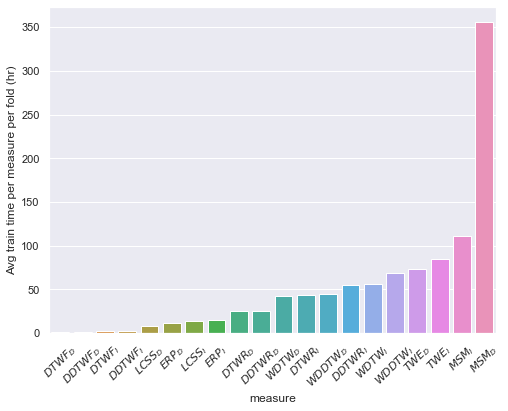

In [198]:
def plot_time():
    cprint("Avg train time per measure per fold", 'blue')
    df_grp = df_tmp[['name', 'useDependentDims','trainTime', 'fold']].groupby(['name', 'useDependentDims', 'fold']).sum()/3600
    df_grp = df_grp.groupby(['name', 'useDependentDims']).mean()
    df_grp = df_grp.sort_values(by=['trainTime'])
    df_grp.drop('euc',  axis=0, inplace=True)
    df_grp.reset_index(inplace=True)
    df_grp['measure'] = df_grp.apply(lambda x : '$'+ x['name'].upper() + '_{D}$' if x['useDependentDims'] == True else '$' + x['name'].upper() + '_{I}$', axis = 1)
    display(df_grp)

    sns.set()
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x="measure", y="trainTime", data=df_grp)
    ax.set_xlabel("measure", fontsize = 12)
    ax.set_ylabel("Avg train time per measure per fold (hr)", fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
    prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/"
    ax.figure.savefig(f"{prod_outdir}/figures/bar-prob-test-i1d2-norm-runtime.pdf", bbox_inches='tight',pad_inches=0.1)
    plt.show()

plot_time()

# Visualization
---

In [82]:
def generate_heatmap_data(input_dir, output_dir, train_test = 'test', voting_scheme='majority', save = False):

    df_ee = pd.read_csv(f"{output_dir}/knn-{train_test}-{voting_scheme}.ee.csv", index_col=False)
#     display(df_ee.head(2))

    # select and reorder columns
    measures = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe']
    columns = [m + '_i_i' for m in measures] + [m + '_d_d' for m in measures]  
    columns = ['dataset'] + columns + ['ee_i', 'ee_d']
#     display(_columns)
    df_ee = df_ee[columns]
    display(df_ee.head(2))
    
#     [m + '_i' for m in _measures if m not in extra_columns]

    df_map = pd.DataFrame (index=df_ee['dataset'], columns = measures)
    df_indep = pd.DataFrame (index=df_ee['dataset'], columns = measures)
    df_dep = pd.DataFrame (index=df_ee['dataset'], columns = measures)
    
    for i in range(df_ee.shape[0]):
        row = df_ee.iloc[i]
#         print(row)
        for column in columns:
            dataset = row['dataset']
            
            # skip if its not a classifier name
            if column[:-4] not in measures:
                continue
                
            measure = column[:-4] # 
#             print(measure)
            
            indep = row[measure + '_i_i']
            dep = row[measure + '_d_d']
            df_map.loc[dataset, measure] = indep - dep
            df_indep.loc[dataset, measure] = indep
            df_dep.loc[dataset, measure] = dep
#             df_map.loc[d, m] = indep - row['dtwf_i']
#             df_map.loc[d, m] = indep - row['lcss_i'] if dep - indep < 0 else dep - row['lcss_i']
#             df_map.loc[d, m] = indep - row['euc_i']
#         break;
    
#     df_map = df_map.dropna()
#     df_map = df_map.reset_index()
#     df_dep = df_dep.dropna()
#     df_indep = df_indep.dropna()
    df_map = uae_mts_archive.merge(df_map, on='dataset')
    df_indep = uae_mts_archive.merge(df_indep, on='dataset')
    df_indep['useDependentDims'] = False
    df_dep = uae_mts_archive.merge(df_dep, on='dataset')
    df_dep['useDependentDims'] = True

    if save:
        df_map.to_csv(f"{output_dir}/heatmap-{voting_scheme}-{train_test}.csv")
        df_indep.to_csv(f"{output_dir}/heatmap-{voting_scheme}-{train_test}-i.csv")
        df_dep.to_csv(f"{output_dir}/heatmap-{voting_scheme}-{train_test}-d.csv")
    
    return df_map, df_indep, df_dep


random_state=None  
random_state=6463564

prod_indir = "E:/git/experiments/knn/23-8-2020/train/"
prod_outdir = "E:/git/experiments/knn/23-8-2020/test/"

dev_indir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/"
dev_outdir = "E:/git/dotnet54/TS-CHIEF-DEV/out/knn/dev/test"

config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"

datasets = get_datasets_in_path(prod_outdir)
# datasets = 'ERing,BasicMotions,Libras'.split(",")
voting_scheme='prob'

# df_heatmap, df_indep, df_dep = generate_heatmap_data(prod_indir, prod_outdir, train_test='train', voting_scheme=voting_scheme)
# display(df_heatmap)
# display(df_indep)
# display(df_dep)


df_heatmap, df_indep, df_dep = generate_heatmap_data(prod_indir, prod_outdir, train_test='test', voting_scheme=voting_scheme, save = True)
display(df_heatmap)
display(df_indep)
display(df_dep)

,dataset,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,ee_i,ee_d
0,ArticularyWordRecognition,0.9760,0.9873,0.9863,0.6243,0.7097,0.9867,0.7190,0.9860,0.9843,0.9863,0.9720,0.9707,0.9893,0.9860,0.3383,0.3417,0.9850,0.3450,0.9793,0.9847,0.9787,0.9700,0.9883,0.9853
1,AtrialFibrillation,0.3067,0.2067,0.2533,0.2267,0.3000,0.2867,0.3267,0.2867,0.2933,0.3267,0.3333,0.3533,0.2133,0.3133,0.2267,0.2867,0.3400,0.3000,0.3400,0.3333,0.2933,0.3267,0.2667,0.3467


,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe
0,ArticularyWordRecognition,275,300,9,144,25,0.0053,-0.0020,0.0003,0.2860,0.3680,0.0017,0.3740,0.0067,-0.0003,0.0077,0.0020
1,AtrialFibrillation,15,15,2,640,3,-0.0467,-0.0067,-0.0600,-0.0000,0.0133,-0.0533,0.0267,-0.0533,-0.0400,0.0333,0.0067
2,BasicMotions,40,40,6,100,4,-0.0150,0.0400,0.0375,0.1000,0.1050,0.0375,0.1000,0.1475,0.2375,0.1700,0.1100
3,Cricket,108,72,6,1197,12,-0.0208,-0.0014,-0.0014,0.1417,0.1444,-0.0028,0.1403,-0.0111,-0.0097,-0.0069,0.0250
4,DuckDuckGeese,50,50,1345,270,5,0.0120,0.1000,0.0920,0.2320,0.1840,0.1020,0.1880,0.0380,0.2540,0.1120,0.3220
5,Epilepsy,137,138,3,206,4,0.0333,0.0080,0.0123,0.0543,0.0551,0.0152,0.0565,0.0457,0.0391,0.0123,0.0486
6,ERing,30,270,4,65,6,0.0026,-0.0215,-0.0022,0.0126,0.0704,0.0119,0.0485,0.0074,0.0207,0.0111,0.0144
7,EthanolConcentration,261,263,3,1751,4,0.0049,-0.0068,-0.0015,0.0338,0.0118,-0.0198,0.0030,-0.0563,-0.0308,0.0194,0.0228
8,FingerMovements,316,100,28,50,2,-0.0050,0.0270,0.0260,0.0070,0.0470,-0.0010,0.0190,0.0460,0.0370,0.0000,-0.0030
9,HandMovementDirection,160,74,10,400,4,0.0122,-0.0122,-0.0216,0.0297,0.0500,0.0149,0.0000,0.0932,0.0959,0.0027,0.0797


,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe,useDependentDims
0,ArticularyWordRecognition,275,300,9,144,25,0.9760,0.9873,0.9863,0.6243,0.7097,0.9867,0.7190,0.9860,0.9843,0.9863,0.9720,False
1,AtrialFibrillation,15,15,2,640,3,0.3067,0.2067,0.2533,0.2267,0.3000,0.2867,0.3267,0.2867,0.2933,0.3267,0.3333,False
2,BasicMotions,40,40,6,100,4,0.5650,1.0000,0.9975,0.9950,0.9975,0.9975,0.9950,0.9075,1.0000,0.9150,1.0000,False
3,Cricket,108,72,6,1197,12,0.9028,0.9986,0.9986,0.9653,0.9722,0.9972,0.9639,0.9833,0.9889,0.9750,0.9847,False
4,DuckDuckGeese,50,50,1345,270,5,0.4300,0.5840,0.5700,0.5840,0.5340,0.5760,0.5400,0.4400,0.5400,0.4920,0.5760,False
5,Epilepsy,137,138,3,206,4,0.6812,0.9681,0.9667,0.9514,0.9500,0.9674,0.9507,0.9725,0.9754,0.8993,0.9710,False
6,ERing,30,270,4,65,6,0.9278,0.9170,0.9381,0.8296,0.9244,0.9456,0.8919,0.9256,0.9326,0.9400,0.9304,False
7,EthanolConcentration,261,263,3,1751,4,0.2932,0.2928,0.2920,0.2730,0.2544,0.2677,0.2574,0.2525,0.2867,0.3053,0.2871,False
8,FingerMovements,316,100,28,50,2,0.5410,0.5740,0.5680,0.5090,0.5490,0.5450,0.5210,0.5400,0.5540,0.5470,0.5310,False
9,HandMovementDirection,160,74,10,400,4,0.2838,0.2986,0.3054,0.3203,0.3135,0.3243,0.2959,0.3149,0.3081,0.2351,0.3324,False


,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe,useDependentDims
0,ArticularyWordRecognition,275,300,9,144,25,0.9707,0.9893,0.9860,0.3383,0.3417,0.9850,0.3450,0.9793,0.9847,0.9787,0.9700,True
1,AtrialFibrillation,15,15,2,640,3,0.3533,0.2133,0.3133,0.2267,0.2867,0.3400,0.3000,0.3400,0.3333,0.2933,0.3267,True
2,BasicMotions,40,40,6,100,4,0.5800,0.9600,0.9600,0.8950,0.8925,0.9600,0.8950,0.7600,0.7625,0.7450,0.8900,True
3,Cricket,108,72,6,1197,12,0.9236,1.0000,1.0000,0.8236,0.8278,1.0000,0.8236,0.9944,0.9986,0.9819,0.9597,True
4,DuckDuckGeese,50,50,1345,270,5,0.4180,0.4840,0.4780,0.3520,0.3500,0.4740,0.3520,0.4020,0.2860,0.3800,0.2540,True
5,Epilepsy,137,138,3,206,4,0.6478,0.9601,0.9543,0.8971,0.8949,0.9522,0.8942,0.9268,0.9362,0.8870,0.9225,True
6,ERing,30,270,4,65,6,0.9252,0.9385,0.9404,0.8170,0.8541,0.9337,0.8433,0.9181,0.9119,0.9289,0.9159,True
7,EthanolConcentration,261,263,3,1751,4,0.2882,0.2996,0.2935,0.2392,0.2426,0.2875,0.2544,0.3087,0.3175,0.2859,0.2643,True
8,FingerMovements,316,100,28,50,2,0.5460,0.5470,0.5420,0.5020,0.5020,0.5460,0.5020,0.4940,0.5170,0.5470,0.5340,True
9,HandMovementDirection,160,74,10,400,4,0.2716,0.3108,0.3270,0.2905,0.2635,0.3095,0.2959,0.2216,0.2122,0.2324,0.2527,True


(23, 18)
(23, 18)
(23, 18)
(23, 18)


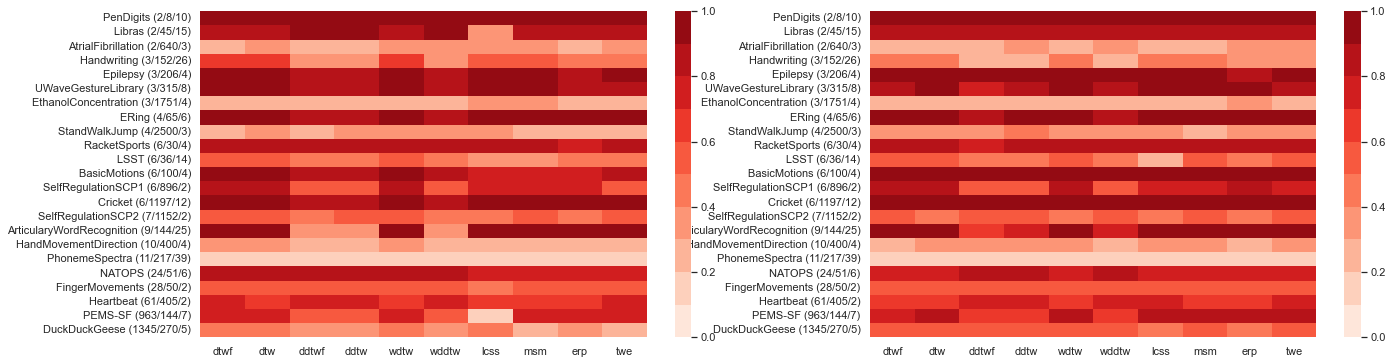

In [83]:
sns.set()

train_test='test'
voting_scheme='prob'

config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"

df_indep = pd.read_csv(f"{prod_outdir}/heatmap-{voting_scheme}-{train_test}-i.csv", index_col=0)
df_dep = pd.read_csv(f"{prod_outdir}/heatmap-{voting_scheme}-{train_test}-d.csv", index_col=0)

df_indep = df_indep.rename(columns={'dtwr': 'dtw', 'ddtwr': 'ddtw'})
df_dep = df_dep.rename(columns={'dtwr': 'dtw', 'ddtwr': 'ddtw'})
print(df_indep.shape)
print(df_dep.shape)

# df_indep = df_indep.dropna()
# df_dep = df_dep.dropna()

# df_indep = df_indep.fillna(0)
# df_dep = df_dep.fillna(0)

print(df_indep.shape)
print(df_dep.shape)

df_indep = df_indep.sort_values(by=['dimensions', 'length', 'classes'])
df_dep = df_dep.sort_values(by=['dimensions', 'length', 'classes'])

fig, ax = plt.subplots(1,2, figsize=(22,6))

ylabels = df_dep['dataset'] + " (" + df_dep['dimensions'].map(str) + "/" + df_dep['length'].map(str) + "/" + df_dep['classes'].map(str) + ")" 
start_col = 7
end_col = -1
sns_plot1 = sns.heatmap(df_indep.iloc[:, start_col: end_col], cmap=sns.color_palette("Reds", 10), vmin=-0, vmax=1, ax=ax[1],yticklabels=ylabels)
sns_plot2 = sns.heatmap(df_dep.iloc[:, start_col: end_col], cmap=sns.color_palette("Reds", 10), vmin=-0, vmax=1, ax=ax[0],yticklabels=ylabels)
# sns.heatmap(df_indep, cmap=sns.color_palette("RdBu_r", 20), vmin=-0, vmax=1, ax=ax[1])
# sns.heatmap(df_dep, cmap=sns.color_palette("RdBu_r", 20), vmin=-0, vmax=1, ax=ax[0])

sns_plot1.figure.savefig(f"{prod_outdir}/figures/heatmap-indep-{train_test}-{voting_scheme}-{config}.pdf", bbox_inches='tight',pad_inches=0.1)
sns_plot2.figure.savefig(f"{prod_outdir}/figures/heatmap-dep-{train_test}-{voting_scheme}-{config}.pdf", bbox_inches='tight',pad_inches=0.1)

(23, 17)
(23, 17)
data columns = 7 to 17


C:\Users\shifaz\AppData\Local\Temp/ipykernel_34312/608461251.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df_heatmap = df_heatmap.dropna(0)


,dtwf,dtw,ddtwf,ddtw,wdtw,wddtw,lcss,msm,erp,twe
0,-0.0020,0.0003,0.2860,0.3680,0.0017,0.3740,0.0067,-0.0003,0.0077,0.0020
1,-0.0067,-0.0600,-0.0000,0.0133,-0.0533,0.0267,-0.0533,-0.0400,0.0333,0.0067


,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtw,ddtwf,ddtw,wdtw,wddtw,lcss,msm,erp,twe,avg_diff
4,DuckDuckGeese,50,50,1345,270,5,0.0120,0.1000,0.0920,0.2320,0.1840,0.1020,0.1880,0.0380,0.2540,0.1120,0.3220,0.1624
15,PEMS-SF,267,173,963,144,7,0.0382,0.0098,0.0382,0.0902,0.0902,0.0364,0.0977,0.7243,0.0382,0.0526,0.0618,0.1239
2,BasicMotions,40,40,6,100,4,-0.0150,0.0400,0.0375,0.1000,0.1050,0.0375,0.1000,0.1475,0.2375,0.1700,0.1100,0.1085
0,ArticularyWordRecognition,275,300,9,144,25,0.0053,-0.0020,0.0003,0.2860,0.3680,0.0017,0.3740,0.0067,-0.0003,0.0077,0.0020,0.1044
13,LSST,2459,2466,6,36,14,-0.0009,0.0203,0.0187,0.0537,0.0530,0.0182,0.0552,-0.0683,0.1818,0.0007,0.0852,0.0419
3,Cricket,108,72,6,1197,12,-0.0208,-0.0014,-0.0014,0.1417,0.1444,-0.0028,0.1403,-0.0111,-0.0097,-0.0069,0.0250,0.0418
5,Epilepsy,137,138,3,206,4,0.0333,0.0080,0.0123,0.0543,0.0551,0.0152,0.0565,0.0457,0.0391,0.0123,0.0486,0.0347
19,SelfRegulationSCP1,268,293,6,896,2,0.0003,-0.0177,-0.0092,0.0334,0.0297,-0.0061,0.0263,0.0215,0.0215,0.0024,0.2365,0.0338
9,HandMovementDirection,160,74,10,400,4,0.0122,-0.0122,-0.0216,0.0297,0.0500,0.0149,0.0000,0.0932,0.0959,0.0027,0.0797,0.0332
12,Libras,180,180,2,45,15,-0.0033,-0.0106,-0.0056,-0.0567,-0.0539,-0.0111,-0.0511,0.5067,-0.0200,-0.0006,-0.0189,0.0278


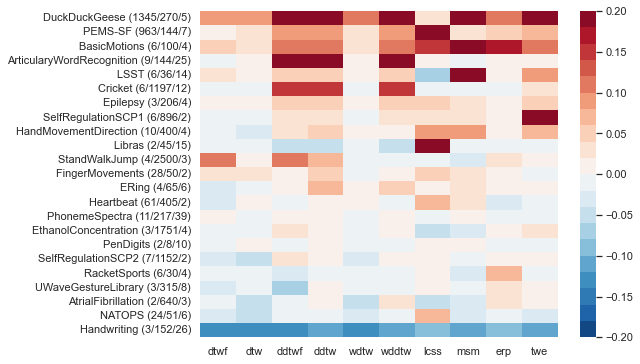

In [84]:
train_test='test'
voting_scheme='prob'

config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"
# config_names = ["i1d2-norm", "i1d2+norm", "i2d2-norm", "i2d2+norm"]
config_names = ["i1d2-norm"]

sort_order = '-avg'

for config in config_names:
    prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
    prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"

    df_heatmap = pd.read_csv(f"{prod_outdir}/heatmap-{voting_scheme}-{train_test}.csv", index_col=0)

    df_heatmap = df_heatmap.rename(columns={'dtwr': 'dtw', 'ddtwr': 'ddtw'})
    print(df_heatmap.shape)
    df_heatmap = df_heatmap.dropna(0)
    # df_heatmap = df_heatmap.fillna(0)
    print(df_heatmap.shape)

    start_column = list(df_heatmap.columns).index("dtwf")
    end_column = list(df_heatmap.columns).index("twe") + 1
    print(f"data columns = {start_column} to {end_column}")
    display(df_heatmap.iloc[:,start_column: end_column].head(2))

    df_heatmap['avg_diff'] = df_heatmap.iloc[:,start_column: end_column].mean(axis=1, numeric_only=True)


#     df_heatmap = df_heatmap.sort_values(by=['dataset'])
#     df_heatmap = df_heatmap.sort_values(by=['dimensions', 'dataset', 'length'])
    df_heatmap = df_heatmap.sort_values(by=['avg_diff'], ascending=False)
    display(df_heatmap.head(20))

    sns.set()
    plt.figure(figsize=(8,6))
    color_scale=0.20
    ylabels = df_heatmap['dataset'] + " (" + df_heatmap['dimensions'].map(str) + "/" + df_heatmap['length'].map(str) + "/" + df_heatmap['classes'].map(str) + ")" 

    sns_plot = sns.heatmap(df_heatmap.iloc[:,start_column: end_column], 
                           cmap=sns.color_palette("RdBu_r", 20), vmin=-color_scale, vmax=color_scale,yticklabels=ylabels)
    sns_plot.figure.savefig(f"{prod_outdir}/figures/heatmap-{train_test}-{voting_scheme}-{config}.pdf", bbox_inches='tight',pad_inches=0.1)

    # latex_out = "E:/git/ahmedshifaz/multivariate-elastic-measures/fig/"
    # sns_plot.figure.savefig(f"{latex_out}/heatmap-{train_test}-{voting_scheme}-{config}{sort_order}.pdf", bbox_inches='tight',pad_inches=0.1)

In [174]:
def color_negative_red(val):
    if isinstance(val, float):
        fgcolor = 'white' if val < 0 else 'black'
        if val < 0:
            bgcolor = '#FF0000'
        elif val == 0:
            bgcolor = '#FFFF00'
        else:
            bgcolor = 'white'
    #     red = hex(int(val) % 255)
    #     bgcolor = f'#{red}0000' if val < 0 else 'white'
        return f'background-color: {bgcolor}; color: {fgcolor}'
    else:
        return ""
    
df_heatmap = df_heatmap.drop(columns=['avg_diff'])
df_heatmap_s = df_heatmap.style.applymap(color_negative_red).format('{:.2%}', pd.IndexSlice[:,df_heatmap.columns[6:]])
df_heatmap_s

,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtw,ddtwf,ddtw,wdtw,wddtw,lcss,msm,erp,twe
4,DuckDuckGeese,50,50,1345,270,5,1.20%,10.00%,9.20%,23.20%,18.40%,10.20%,18.80%,4.60%,25.40%,11.20%,32.20%
15,PEMS-SF,267,173,963,144,7,3.82%,0.98%,3.82%,9.02%,9.02%,3.64%,9.77%,72.54%,3.82%,5.26%,6.18%
2,BasicMotions,40,40,6,100,4,-1.50%,4.00%,3.75%,10.00%,10.50%,3.75%,10.00%,14.75%,23.75%,17.00%,11.00%
0,ArticularyWordRecognition,275,300,9,144,25,0.53%,-0.20%,0.03%,28.60%,36.80%,0.17%,37.40%,0.67%,-0.03%,0.77%,0.20%
13,LSST,2459,2466,6,36,14,-0.09%,2.03%,1.87%,5.37%,5.30%,1.82%,5.52%,-6.41%,18.18%,0.07%,8.52%
3,Cricket,108,72,6,1197,12,-2.08%,-0.14%,-0.14%,14.17%,14.44%,-0.28%,14.03%,-1.11%,-0.97%,-0.69%,2.50%
5,Epilepsy,137,138,3,206,4,3.33%,0.80%,1.23%,5.43%,5.51%,1.52%,5.65%,4.49%,3.91%,1.23%,4.86%
19,SelfRegulationSCP1,268,293,6,896,2,0.03%,-1.77%,-0.92%,3.34%,2.97%,-0.61%,2.63%,2.08%,2.15%,0.24%,23.65%
9,HandMovementDirection,160,74,10,400,4,1.22%,-1.22%,-2.16%,2.97%,5.00%,1.49%,0.00%,9.73%,9.59%,0.27%,7.97%
21,StandWalkJump,12,15,4,2500,3,-0.67%,12.00%,0.00%,11.33%,6.00%,-1.33%,-0.67%,-1.33%,-3.33%,3.33%,2.00%


# Statistical Tests

### Random data

In [186]:
def tmp():
    # Wilcoxon tests using random numbers -- for learning
    import scipy as sp
    print(sp.__version__)

    data = np.random.uniform(-1,0,1) + np.random.uniform(5,0,10)
    print(data)
    w, p = stats.wilcoxon(data,zero_method='zsplit', correction=False, alternative='two-sided', mode='exact')
    print(f"two-sided w (sum of the ranks of the differences above or below zero, whichever is smaller): {w}, p: {p}")
    w, p = stats.wilcoxon(data,zero_method='zsplit', correction=True, alternative='greater', mode='exact')
    print(f"one-sided w (sum of the ranks of the differences above zero): {w}, p: {p}")

    data = np.random.uniform(-1,0,10) + np.random.uniform(5,0,1)
    print(data)
    w, p = stats.wilcoxon(data,zero_method='zsplit', correction=False, alternative='two-sided', mode='exact')
    print(f"two-sided w (sum of the ranks of the differences above or below zero, whichever is smaller): {w}, p: {p}")
    w, p = stats.wilcoxon(data,zero_method='zsplit', correction=True, alternative='greater', mode='exact')
    print(f"one-sided w (sum of the ranks of the differences above zero): {w}, p: {p}")

tmp()

1.7.3
[1.85896905 3.97556789 1.09562391 4.80426749 4.5897371  2.67495211
 3.25437589 2.83850547 2.16678177 3.97865359]
two-sided w (sum of the ranks of the differences above or below zero, whichever is smaller): 0.0, p: 0.001953125
one-sided w (sum of the ranks of the differences above zero): 55.0, p: 0.0009765625
[0.45156212 0.88066371 0.45846451 0.95078675 0.21875493 0.54466368
 0.0694648  0.66509432 0.26972431 0.15406652]
two-sided w (sum of the ranks of the differences above or below zero, whichever is smaller): 0.0, p: 0.001953125
one-sided w (sum of the ranks of the differences above zero): 55.0, p: 0.0009765625


### Test on a single dataset

In [196]:
# try wilcoxon test for a single dataset

def stat_test_one_dataset(dataset):
    df_stats = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/heatmap-prob-test.csv", index_col=0)
    df_stats = df_stats.set_index('dataset', drop=True)
    print(df_stats.index)
    display(df_stats.head())


    data = df_stats.loc[dataset].iloc[6:]#.drop(['ee'])
    print(data)

    w, p = stats.wilcoxon(data,zero_method='zsplit', correction=False, alternative='two-sided', mode='exact')
    print(f"two-sided w (sum of the ranks of the differences above or below zero, whichever is smaller): {w}, p: {p}")
    w, p = stats.wilcoxon(data,zero_method='zsplit', correction=True, alternative='greater', mode='exact')
    print(f"one-sided w (sum of the ranks of the differences above zero): {w}, p: {p}")

stat_test_one_dataset('Handwriting')

Index(['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'Cricket', 'DuckDuckGeese', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'Libras', 'LSST', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'StandWalkJump', 'UWaveGestureLibrary'], dtype='object', name='dataset')


,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe
dataset,,,,,,,,,,,,,,,,
ArticularyWordRecognition,275,300,9,144,25,0.0053,-0.0020,0.0003,0.2860,0.3680,0.0017,0.3740,0.0067,-0.0003,0.0077,0.0020
AtrialFibrillation,15,15,2,640,3,-0.0467,-0.0067,-0.0600,0.0000,0.0133,-0.0533,0.0267,-0.0467,-0.0400,0.0333,0.0067
BasicMotions,40,40,6,100,4,-0.0150,0.0400,0.0375,0.1000,0.1050,0.0375,0.1000,0.1475,0.2375,0.1700,0.1100
Cricket,108,72,6,1197,12,-0.0208,-0.0014,-0.0014,0.1417,0.1444,-0.0028,0.1403,-0.0111,-0.0097,-0.0069,0.0250
DuckDuckGeese,50,50,1345,270,5,0.0120,0.1000,0.0920,0.2320,0.1840,0.1020,0.1880,0.0460,0.2540,0.1120,0.3220


dtwf    -0.1295
dtwr    -0.1355
ddtwf   -0.1213
ddtwr   -0.1028
wdtw    -0.1280
wddtw   -0.1031
lcss    -0.0804
msm     -0.1006
erp     -0.0845
twe     -0.1086
Name: Handwriting, dtype: float64
two-sided w (sum of the ranks of the differences above or below zero, whichever is smaller): 0.0, p: 0.001953125
one-sided w (sum of the ranks of the differences above zero): 0.0, p: 1.0


In [85]:
# https://github.com/puolival/multipy/blob/master/multipy/fwer.py

def holm_bonferroni(pvals, alpha=0.05):
    """A function for controlling the FWER using the Holm-Bonferroni
    procedure [2].
    Input arguments:
    pvals       - P-values corresponding to a family of hypotheses.
    alpha       - The desired family-wise error rate.
    Output arguments:
    significant - An array of flags indicating which p-values are significant
                  after correcting for multiple comparisons.
    """
    m, pvals = len(pvals), np.asarray(pvals)
    ind = np.argsort(pvals)
    test = [p > alpha/(m+1-k) for k, p in enumerate(pvals[ind])]

    """The minimal index k is m-np.sum(test)+1 and the hypotheses 1, ..., k-1
    are rejected. Hence m-np.sum(test) gives the correct number."""
    significant = np.zeros(np.shape(pvals), dtype='bool')
    significant[ind[0:m-np.sum(test)]] = True
    return significant


In [87]:
# notes, use two sided, exact with zplit
# notes, use two sided, exact with zplit
train_test='test'
voting_scheme='prob'

config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"

# config_names = ["i1d2-norm", "i1d2+norm", "i2d2-norm", "i2d2+norm"]
config_names = ["i1d2-norm"]
for config in config_names:
    prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/train/"
    prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"
    prod_indir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/train/"
    prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"

    df_stats = pd.read_csv(f"{prod_outdir}/heatmap-{voting_scheme}-{train_test}.csv", index_col=0)

    #remove euc and other columns
    df_stats = df_stats[['dataset', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe']]
    df_stats = df_stats.set_index('dataset')
    display(df_stats.head(5))


    correction_method = 'holm'

    df_wilcoxon = pd.DataFrame (index=df_stats.index, columns = ['w_two_side', 'p_two_side','sig_p','sig_table','w_one_side', 'p_one_side', 
                                                                 'sig_after_correction', 'pvals_corrected', 'alphacBonf'])

    # default args
    # zero_method = 'wilcox'
    # mode = 'auto'

    zero_method = 'zsplit'
    mode = 'exact'

    # print(df_stats)
    for d in df_stats.index:
        row = df_stats.loc[d]
    #     print(data)
        w2, p2 = stats.wilcoxon(row,zero_method=zero_method, correction=False, alternative='two-sided', mode=mode)
    #     print(w2, p2)
        w1, p1 = stats.wilcoxon(row,zero_method=zero_method, correction=False, alternative='greater', mode=mode)
    #     print(w1, p1)
        df_wilcoxon.at[d,'w_two_side'] = w2
        df_wilcoxon.at[d,'p_two_side'] = p2
        df_wilcoxon.at[d,'sig_p'] = True if p2 < 0.05 else False
    #     http://www.real-statistics.com/statistics-tables/wilcoxon-signed-ranks-table/
        df_wilcoxon.at[d,'sig_table'] = True if w2 < 8 else False
        df_wilcoxon.at[d,'w_one_side'] = w1
        df_wilcoxon.at[d,'p_one_side'] = p1

    df_wilcoxon.reset_index()
    df_wilcoxon = df_wilcoxon.sort_values(by='p_two_side')

    df_wilcoxon.to_csv(f"{prod_outdir}/wilcoxon-{voting_scheme}-{train_test}.csv")
    display(df_wilcoxon)

,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe
dataset,,,,,,,,,,
ArticularyWordRecognition,-0.0020,0.0003,0.2860,0.3680,0.0017,0.3740,0.0067,-0.0003,0.0077,0.0020
AtrialFibrillation,-0.0067,-0.0600,-0.0000,0.0133,-0.0533,0.0267,-0.0533,-0.0400,0.0333,0.0067
BasicMotions,0.0400,0.0375,0.1000,0.1050,0.0375,0.1000,0.1475,0.2375,0.1700,0.1100
Cricket,-0.0014,-0.0014,0.1417,0.1444,-0.0028,0.1403,-0.0111,-0.0097,-0.0069,0.0250
DuckDuckGeese,0.1000,0.0920,0.2320,0.1840,0.1020,0.1880,0.0380,0.2540,0.1120,0.3220


C:\Users\shifaz\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,w_two_side,p_two_side,sig_p,sig_table,w_one_side,p_one_side,sig_after_correction,pvals_corrected,alphacBonf
dataset,,,,,,,,,
BasicMotions,0.0000,0.0020,True,True,55.0000,0.0010,NaN,NaN,NaN
DuckDuckGeese,0.0000,0.0020,True,True,55.0000,0.0010,NaN,NaN,NaN
Epilepsy,0.0000,0.0020,True,True,55.0000,0.0010,NaN,NaN,NaN
PEMS-SF,0.0000,0.0020,True,True,55.0000,0.0010,NaN,NaN,NaN
Handwriting,0.0000,0.0020,True,True,0.0000,1.0000,NaN,NaN,NaN
FingerMovements,5.5000,0.0249,True,True,49.5000,0.0125,NaN,NaN,NaN
ArticularyWordRecognition,6.5000,0.0371,True,True,48.5000,0.0186,NaN,NaN,NaN
LSST,8.0000,0.0488,True,False,47.0000,0.0244,NaN,NaN,NaN
HandMovementDirection,8.5000,0.0528,False,False,46.5000,0.0264,NaN,NaN,NaN


In [88]:
# print(df_wilcoxon.shape)
stats.binom_test(7, n=23, p=0.05, alternative='greater')
# https://www.rdocumentation.org/packages/exactRankTests/versions/0.8-31/topics/wilcox.exact
# 0.05/19

9.40098282952001e-05

In [90]:
# https://github.com/puolival/multipy/blob/master/multipy/fwer.py

def holm_bonferroni(pvals, alpha=0.05):
    """A function for controlling the FWER using the Holm-Bonferroni
    procedure [2].
    Input arguments:
    pvals       - P-values corresponding to a family of hypotheses.
    alpha       - The desired family-wise error rate.
    Output arguments:
    significant - An array of flags indicating which p-values are significant
                  after correcting for multiple comparisons.
    """
    m, pvals = len(pvals), np.asarray(pvals)
    ind = np.argsort(pvals)
    
    _corrected_pvals = [alpha/(m+1-k) for k, p in enumerate(pvals[ind])]  # temp
    
    test = [p > alpha/(m+1-k) for k, p in enumerate(pvals[ind])]

    """The minimal index k is m-np.sum(test)+1 and the hypotheses 1, ..., k-1
    are rejected. Hence m-np.sum(test) gives the correct number."""
    significant = np.zeros(np.shape(pvals), dtype='bool')
    significant[ind[0:m-np.sum(test)]] = True
    return significant, test, _corrected_pvals



# config_names = ["i1d2-norm", "i1d2+norm", "i2d2-norm", "i2d2+norm"]
config_names = ["i1d2-norm"]
for config in config_names:
    # prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"
    prod_outdir = f"E:/git/experiments/knn/10-2-2022/m3/{config}/test/"

    df_wilcoxon = pd.read_csv(f"{prod_outdir}/wilcoxon-{voting_scheme}-{train_test}.csv", index_col=0)

    _significant, _test, _corrected_pvals = holm_bonferroni(df_wilcoxon['p_two_side'], 0.05)

    df_wilcoxon['sig_after_correction'] = _significant
    df_wilcoxon['pvals_corrected'] = _corrected_pvals
    df_wilcoxon.to_csv(f"{prod_outdir}/wilcoxon-{voting_scheme}-{train_test}-holm.csv")
    display(df_wilcoxon)

,w_two_side,p_two_side,sig_p,sig_table,w_one_side,p_one_side,sig_after_correction,pvals_corrected,alphacBonf
dataset,,,,,,,,,
BasicMotions,0.0000,0.0020,True,True,55.0000,0.0010,True,0.0021,NaN
DuckDuckGeese,0.0000,0.0020,True,True,55.0000,0.0010,True,0.0022,NaN
Epilepsy,0.0000,0.0020,True,True,55.0000,0.0010,True,0.0023,NaN
PEMS-SF,0.0000,0.0020,True,True,55.0000,0.0010,True,0.0024,NaN
Handwriting,0.0000,0.0020,True,True,0.0000,1.0000,True,0.0025,NaN
FingerMovements,5.5000,0.0249,True,True,49.5000,0.0125,False,0.0026,NaN
ArticularyWordRecognition,6.5000,0.0371,True,True,48.5000,0.0186,False,0.0028,NaN
LSST,8.0000,0.0488,True,False,47.0000,0.0244,False,0.0029,NaN
HandMovementDirection,8.5000,0.0528,False,False,46.5000,0.0264,False,0.0031,NaN


In [91]:
config = "i1d2-norm"
# config = "i1d2+norm"
# config = "i2d2-norm"
# config = "i2d2+norm"
prod_indir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/train/"
prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"
df_tmp = pd.read_csv(f"{prod_outdir}/wilcoxon-{voting_scheme}-{train_test}-holm.csv", index_col=0)
display(df_tmp)
print(df_tmp.shape)

,w_two_side,p_two_side,sig_p,sig_table,w_one_side,p_one_side,sig_after_correction,pvals_corrected,alphacBonf
dataset,,,,,,,,,
BasicMotions,0.0000,0.0020,True,True,55.0000,0.0010,True,0.0021,NaN
PEMS-SF,0.0000,0.0020,True,True,55.0000,0.0010,True,0.0022,NaN
Handwriting,0.0000,0.0020,True,True,0.0000,1.0000,True,0.0023,NaN
HandMovementDirection,2.0000,0.0059,True,True,53.0000,0.0029,False,0.0024,NaN
LSST,2.0000,0.0059,True,True,53.0000,0.0029,False,0.0025,NaN
Epilepsy,2.5000,0.0103,True,True,52.5000,0.0052,False,0.0026,NaN
ArticularyWordRecognition,6.0000,0.0282,True,True,49.0000,0.0141,False,0.0028,NaN
PhonemeSpectra,14.5000,0.1794,False,False,40.5000,0.0897,False,0.0029,NaN
PenDigits,14.0000,0.1934,False,False,14.0000,0.9199,False,0.0031,NaN


(23, 9)


## Compare configs

In [140]:
# select best accuracy in indep, 
# select best accuracy in dep,
# diff
# make a heat map
# do a stat test

i1d2 = pd.read_csv(f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2-norm/test/knn-test-prob.ee.csv", index_col=0)
i1d2n = pd.read_csv(f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2+norm/test/knn-test-prob.ee.csv", index_col=0)
i2d2 = pd.read_csv(f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/i2d2-norm/test/knn-test-prob.ee.csv", index_col=0)
i2d2n = pd.read_csv(f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/i2d2+norm/test/knn-test-prob.ee.csv", index_col=0)


,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0667,0.2000,0.0000,-0.1333,-0.1333,-0.0667,0.0667,-0.0667,-0.1333,-0.2000,0.0000,-0.0667,0.1333,-0.0667,0.0000,0.0000,0.0000,0.0667,0.0667,-0.0667,-0.0667,0.0000
2,-0.1250,0.1250,0.1250,0.1250,0.1250,0.0750,0.1500,-0.1500,0.0000,-0.0500,0.0500,-0.1250,0.0000,0.0500,0.0750,0.0750,0.0000,0.0750,-0.1000,-0.0750,0.0000,0.0500
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.1400,0.1800,0.1600,0.2800,0.2400,0.1600,0.2000,0.0600,0.3400,0.1200,0.3200,0.2800,0.2600,0.2400,0.1000,0.1000,0.2600,0.1000,0.2200,0.0600,0.1600,0.0600


<AxesSubplot:>

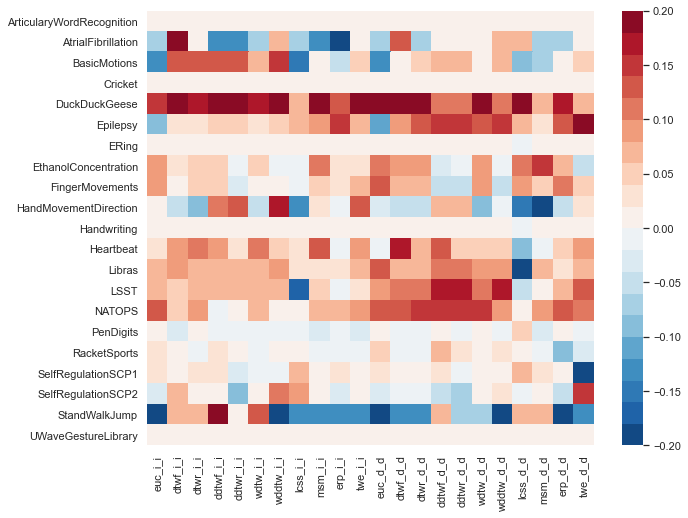

In [177]:
diff = i1d2.iloc[:,7:29] - i1d2n.iloc[:,7:29]
# diff_i2d2 = i2d2.iloc[:,7:29] - i2d2n.iloc[:,7:29]

# diff = i1d2.iloc[:,7:29] - i2d2.iloc[:,7:29]

display(diff.head())

sns.set()
plt.figure(figsize=(10,8))
color_scale=0.20
sns.heatmap(diff, cmap=sns.color_palette("RdBu_r", 20), vmin=-color_scale, vmax=color_scale,yticklabels=i1d2.iloc[:,0])

In [175]:
i1d2.columns[7:29].values

array(['euc_i_i', 'dtwf_i_i', 'dtwr_i_i', 'ddtwf_i_i', 'ddtwr_i_i',
       'wdtw_i_i', 'wddtw_i_i', 'lcss_i_i', 'msm_i_i', 'erp_i_i',
       'twe_i_i', 'euc_d_d', 'dtwf_d_d', 'dtwr_d_d', 'ddtwf_d_d',
       'ddtwr_d_d', 'wdtw_d_d', 'wddtw_d_d', 'lcss_d_d', 'msm_d_d',
       'erp_d_d', 'twe_d_d'], dtype=object)

In [171]:
display(i1d2.head(5))

def tmp():
    rows = i1d2.shape[1]
    columns = i1d2.columns[7:29].values
    
    for c, j in enumerate(columns):
        for i in range(0, rows):
            m = i1d2.iloc[j,i].max()
            display(m)
        
tmp()

,dataset,trainsize,testsize,dimensions,length,classes,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,dtwf_i_b,ddtwf_d_b,ddtwr_d_b,lcss_d_b,msm_i_b,twe_i_b,dtwr_d_b,erp_d_b,euc_i_b,wddtw_d_b,wdtw_d_b
0,ArticularyWordRecognition,275,300,9,144,25,test,0.9733,0.9800,0.9800,0.6000,0.6900,0.9867,0.6967,0.9933,0.9933,0.9867,0.9833,0.9700,0.9867,0.9833,0.3533,0.3433,0.9867,0.3567,0.9833,0.9833,0.9800,0.9700,0.9733,0.9700,0.9800,0.9867,0.9800,0.9833,0.6000,0.3533,0.6900,0.3433,0.9867,0.9867,0.6967,0.3567,0.9933,0.9833,0.9933,0.9833,0.9867,0.9800,0.9833,0.9700,0.9700,0.9867,0.9800,0.6000,0.6900,0.9867,0.6967,0.9933,0.9833,0.9867,0.9700,0.9867,0.9867,0.9867,0.9900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,AtrialFibrillation,15,15,2,640,3,test,0.2667,0.2667,0.2667,0.0667,0.0667,0.1333,0.2667,0.2000,0.2000,0.2667,0.3333,0.2667,0.2000,0.2667,0.1333,0.3333,0.2000,0.2667,0.3333,0.2667,0.2667,0.1333,0.2667,0.2667,0.2667,0.2000,0.2667,0.2667,0.0667,0.1333,0.0667,0.3333,0.1333,0.2000,0.2667,0.2667,0.2000,0.2667,0.2000,0.2667,0.2667,0.2667,0.3333,0.1333,0.2667,nan,0.2000,nan,nan,0.2000,0.2667,nan,0.2667,0.3333,0.3333,0.2000,0.2667,0.2667,0.2000,0.3333,0.1333,0.3333,0.2000,nan,nan,nan,nan,nan,nan,nan
2,BasicMotions,40,40,6,100,4,test,0.6000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.8500,1.0000,0.8500,1.0000,0.6000,0.9750,0.9750,0.9500,0.9500,0.9750,0.9500,0.8000,0.6750,0.7500,0.9500,0.6000,0.6000,1.0000,0.9750,1.0000,0.9750,1.0000,0.9500,1.0000,0.9500,1.0000,0.9750,1.0000,0.9500,0.8500,0.8000,1.0000,0.6750,0.8500,0.7500,1.0000,0.9500,0.6000,nan,1.0000,1.0000,1.0000,1.0000,1.0000,0.8500,nan,0.8500,nan,1.0000,0.9500,0.9750,1.0000,1.0000,nan,nan,nan,1.0000,1.0000,nan,nan,nan,nan,nan
3,Cricket,108,72,6,1197,12,test,0.9167,0.9861,1.0000,0.9583,0.9583,0.9861,0.9583,0.9722,0.9861,0.9583,0.9861,0.9444,1.0000,1.0000,0.7500,0.7778,1.0000,0.7500,0.9861,1.0000,0.9722,0.9722,0.9167,0.9444,0.9861,1.0000,1.0000,1.0000,0.9583,0.7500,0.9583,0.7778,0.9861,1.0000,0.9583,0.7500,0.9722,0.9861,0.9861,1.0000,0.9583,0.9722,0.9861,0.9722,0.9444,1.0000,nan,0.9583,0.9583,1.0000,0.9583,0.9722,1.0000,nan,nan,1.0000,1.0000,1.0000,1.0000,nan,nan,nan,nan,nan,0.9861,1.0000,0.9861,nan,nan,nan
4,DuckDuckGeese,50,50,1345,270,5,test,0.3400,0.4800,0.4800,0.5400,0.5400,0.4800,0.5400,0.3400,0.6000,0.3400,0.6000,0.5000,0.5800,0.5800,0.3200,0.3200,0.5800,0.3200,0.4200,0.2600,0.3600,0.2600,0.3400,0.5000,0.4800,0.5800,0.4800,0.5800,0.5400,0.3200,0.5400,0.3200,0.4800,0.5800,0.5400,0.3200,0.3400,0.4200,0.6000,0.2600,0.3400,0.3600,0.6000,0.2600,nan,nan,0.4800,0.5400,0.5400,0.4800,0.5400,nan,nan,0.3400,nan,0.5400,0.5800,0.6000,0.5400,0.4800,nan,nan,0.4600,0.6000,0.6000,nan,nan,0.3400,nan,nan


0.9733333333333334

0.26666666666666666

0.6

0.9166666666666666

0.34

0.6666666666666666

0.9481481481481482

0.3231939163498099

0.56

0.28378378378378377

0.3352941176470588

0.6634146341463415

0.8166666666666667

0.4541768045417681

0.8222222222222222

0.9777015437392796

0.8026315789473685

0.7781569965870307

0.4833333333333333

0.26666666666666666

0.88125

IndexError: single positional indexer is out-of-bounds

# Latex Tables

In [16]:
%run "E:/git/dotnet54/TS-CHIEF-DEV/experiments/python/latex"

latex.py 14-3-2021.1


In [21]:
class LatexTable:
    version = "1.0.0-4.9.2020-init"

    def __init__(self, df, **kwargs):
        print('init_LatexTable')
        self.df = df
        self.output_dir = kwargs.get('output_dir', '')
        self.float_format = kwargs.get('float_format', '{:.2f}')

    def to_pdlatex(self, file=None, options = None, **kwargs):
        latex_str = self.df.to_latex(**kwargs)
        if file:
            tex_file = open(f"{self.output_dir}{file}", "w")
            tex_file.write(latex_str)
            tex_file.close()
            return latex_str
        else:
            return latex_str

    #     def leq_than_formatter(self, x, threshold):
    #         if x <= threshold:
    #             return f'\textbf{{{str(self.float_format.format(x))}}}'
    #         else:
    #             return float_format.format(x)

    #     def format_significant(self, column):
    #         df_tmp = self.df[column].apply(self.leq_than_formatter, axis=0, result_type=None)
    #         df_tmp = df_tmp[columns] # restore original reorder
    #         return df_tmp

    def format_max_cell(self, x, max_value):
        if x == max_value:
            return f'\textbf{{{str(self.float_format.format(x))}}}'
        else:
            return self.float_format.format(x)

    def format_max_per_row_apply(self, row):
        frow = row.apply(self.format_max_cell, max_value=row.max())
        return frow

    def format_max_per_row(self, columns):
        df_tmp = self.df[columns].apply(self.format_max_per_row_apply, axis=1, result_type=None)
        df_tmp = df_tmp[columns] # restore original reorder
        return df_tmp

    def get_wins_per_column(self, column):
        wins = column.apply(lambda x: 1 if x[:6] == f'\textbf' else 0)
        return wins

    def append_wins(self, columns):
        df_wins = self.df[columns].apply(self.get_wins_per_column, axis=0)
        # display(df_wins)
        wins = df_wins.sum().astype('str')
        return self.df.append(wins, ignore_index=True)

def test_latex_table():
    voting_scheme = 'prob' #  'majority'
    train_test = 'test' # 'train'
    config = 'i1d2-norm' # i1d2-norm i1d2+norm i2d2-norm i2d2+norm
    prod_outdir = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/"
    latex_out = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/figures/"

    df_raw = pd.read_csv(f"{prod_outdir}/heatmap-{voting_scheme}-{train_test}-i.csv", index_col=0)
    # df_raw = df_raw.merge(df_short_names, on='dataset')
    print(df_raw.columns)

    # df_raw = df_raw.apply(lambda series: f'\textbf{{{str(series)}}}')

    display(df_raw.head())
    # display(df_raw.dtypes)

    lt = LatexTable(df_raw, output_dir=latex_out)
    measure_columns = ['euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp','twe']
    lt.df[measure_columns] = lt.format_max_per_row(measure_columns)
    lt.df = lt.append_wins(measure_columns)
    display(lt.df)
    lt.to_pdlatex(file=f'{prod_outdir}/table1.tex', options={},
                  columns=['code', 'euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp','twe'],
                  header=['dataset', 'L2','dtwf', 'dtwcv', 'ddtwf', 'ddtwcv', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp','twe'],
                  #               header=['dataset', 'L2', 'DTWF', 'DTWR', 'DDTWF', 'DDTWR', 'WDTW', 'WDDTW', 'LCSS', 'MSM', 'ERP','TWE'],
                  bold_rows=True,escape=False,
                  column_format='l*{11}{p{0.5cm}}',
                  index=False, label='tbl:table1', caption='Table Caption TODO')#, float_format="%.2f"

test_latex_table();

Index(['dataset', 'trainsize', 'testsize', 'dimensions', 'length', 'classes', 'euc', 'dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe', 'useDependentDims'], dtype='object')


,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe,useDependentDims
0,ArticularyWordRecognition,275,300,9,144,25,0.9760,0.9873,0.9863,0.6243,0.7097,0.9867,0.7190,0.9860,0.9843,0.9863,0.9720,False
1,AtrialFibrillation,15,15,2,640,3,0.3067,0.2067,0.2533,0.2267,0.3000,0.2867,0.3267,0.2867,0.2933,0.3267,0.3333,False
2,BasicMotions,40,40,6,100,4,0.5650,1.0000,0.9975,0.9950,0.9975,0.9975,0.9950,0.9075,1.0000,0.9150,1.0000,False
3,Cricket,108,72,6,1197,12,0.9028,0.9986,0.9986,0.9653,0.9722,0.9972,0.9639,0.9833,0.9889,0.9750,0.9847,False
4,DuckDuckGeese,50,50,1345,270,5,0.4300,0.5840,0.5700,0.5840,0.5340,0.5760,0.5400,0.4400,0.5400,0.4920,0.5760,False


init_LatexTable


,dataset,trainsize,testsize,dimensions,length,classes,euc,dtwf,dtwr,ddtwf,ddtwr,wdtw,wddtw,lcss,msm,erp,twe,useDependentDims
0,ArticularyWordRecognition,275.0000,300.0000,9.0000,144.0000,25.0000,0.98,\textbf{0.99},0.99,0.62,0.71,0.99,0.72,0.99,0.98,0.99,0.97,0.0000
1,AtrialFibrillation,15.0000,15.0000,2.0000,640.0000,3.0000,0.31,0.21,0.25,0.23,0.30,0.29,0.33,0.29,0.29,0.33,\textbf{0.33},0.0000
2,BasicMotions,40.0000,40.0000,6.0000,100.0000,4.0000,0.57,\textbf{1.00},1.00,0.99,1.00,1.00,0.99,0.91,\textbf{1.00},0.92,\textbf{1.00},0.0000
3,Cricket,108.0000,72.0000,6.0000,1197.0000,12.0000,0.90,\textbf{1.00},\textbf{1.00},0.97,0.97,1.00,0.96,0.98,0.99,0.97,0.98,0.0000
4,DuckDuckGeese,50.0000,50.0000,1345.0000,270.0000,5.0000,0.43,\textbf{0.58},0.57,\textbf{0.58},0.53,0.58,0.54,0.44,0.54,0.49,0.58,0.0000
5,Epilepsy,137.0000,138.0000,3.0000,206.0000,4.0000,0.68,0.97,0.97,0.95,0.95,0.97,0.95,0.97,\textbf{0.98},0.90,0.97,0.0000
6,ERing,30.0000,270.0000,4.0000,65.0000,6.0000,0.93,0.92,0.94,0.83,0.92,\textbf{0.95},0.89,0.93,0.93,0.94,0.93,0.0000
7,EthanolConcentration,261.0000,263.0000,3.0000,1751.0000,4.0000,0.29,0.29,0.29,0.27,0.25,0.27,0.26,0.26,0.29,\textbf{0.31},0.29,0.0000
8,FingerMovements,316.0000,100.0000,28.0000,50.0000,2.0000,0.54,\textbf{0.57},0.57,0.51,0.55,0.55,0.52,0.54,0.55,0.55,0.53,0.0000
9,HandMovementDirection,160.0000,74.0000,10.0000,400.0000,4.0000,0.28,0.30,0.31,0.32,0.31,0.32,0.30,0.31,0.31,0.24,\textbf{0.33},0.0000


KeyError: "['code'] not in index"

In [17]:
%run "E:/git/dotnet54/TS-CHIEF-DEV/experiments/python/latex"


def make_datasets_table(input_dir, output_dir, save = False):

    df_mts = pd.read_csv(f"{input_dir}/mts-datasets.csv", index_col=False)
    latex_df, latex_str = df_to_latex_table(df_mts)

    if save:
        latex_df.to_csv(output_dir + "/tmp.csv")



make_datasets_table("E:/tmp/mv_measures_r1/", "E:/tmp/mv_measures_r1/", save = True);

latex.py 14-3-2021.1


ValueError: too many values to unpack (expected 2)

In [24]:
# table-wilcoxon
def table_wilcoxon():
    voting_scheme = 'prob' #  'majority'
    train_test = 'test' # 'train'
    config = 'i1d2-norm' # i1d2-norm i1d2+norm i2d2-norm i2d2+norm
    prod_outdir = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/"
    latex_out = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/figures/"

    df_raw = pd.read_csv(prod_outdir + f"wilcoxon-{voting_scheme}-{train_test}-holm.csv",index_col=False)
    # df_raw = df_raw.merge(df_short_names, left_on='dataset', right_on='dataset')#.drop(columns=['dataset']).rename(columns={'dataset_short': 'dataset'})
    # df_raw = df_raw.sort_values(by=['dataset'])
    # df_raw = df_raw.sort_values(by=['dimensions', 'length', 'classes', 'dataset'])
    # df_raw = df_raw.sort_values(by=['sig_after_correction','pvals_corrected'])
    df_raw = df_raw.sort_values(by=['p_two_side'])

    lt = LatexTable(df_raw, output_dir=latex_out)

    def format_sig_values(series, p_value_column, sig_column):
        if series.loc[sig_column] == True:
            return f"\textbf{{{str('{:.4f}'.format(series.loc[p_value_column]))}}}"
        else:
            return str("{:.4f}".format(series.loc[p_value_column]))

    lt.df[['p_two_side_formatted']] = lt.df[['p_two_side', 'sig_p']].apply(format_sig_values,
                                                                           p_value_column='p_two_side',sig_column='sig_p', axis=1)
    lt.df[['pvals_corrected_formatted']] = lt.df[['pvals_corrected', 'sig_after_correction']].apply(format_sig_values,
                                                                                                    p_value_column='pvals_corrected',
                                                                                                    sig_column='sig_after_correction', axis=1)

    display(df_raw.head(8))

    lt.to_pdlatex(file='table-wilcoxon.tex', options={},
                  columns=['dataset','p_two_side_formatted', 'pvals_corrected_formatted'],
                  header=['dataset','p-value', 'p-value-after-Holm-Bonferroni'],
                  escape=False,index=False,
                  column_format='lrr',float_format="%.4f",
                  label='tbl:wilcoxon',
                  caption='p-values for two-sided Signed Rank Wilcoxon test with $\alpha=0.05$ \
                  (significant values are in bold face) and $\alpha$ values adjusted for multiple testing using the Holm-Bonferroni correction.')

table_wilcoxon()

init_LatexTable


ValueError: Columns must be same length as key

# Critical Difference Diagrams

## CD with all mv measures

critical_diff.py 10-3-2021.1
['ee_i' 'ee_d' 'ee_id' 'ee_b' 'euc_i_i' 'dtwf_i_i' 'dtwr_i_i' 'ddtwf_i_i'
 'ddtwr_i_i' 'wdtw_i_i' 'wddtw_i_i' 'lcss_i_i' 'msm_i_i' 'erp_i_i'
 'twe_i_i' 'euc_d_d' 'dtwf_d_d' 'dtwr_d_d' 'ddtwf_d_d' 'ddtwr_d_d'
 'wdtw_d_d' 'wddtw_d_d' 'lcss_d_d' 'msm_d_d' 'erp_d_d' 'twe_d_d'
 'euc_i_id' 'euc_d_id' 'dtwf_i_id' 'dtwf_d_id' 'dtwr_i_id' 'dtwr_d_id'
 'ddtwf_i_id' 'ddtwf_d_id' 'ddtwr_i_id' 'ddtwr_d_id' 'wdtw_i_id'
 'wdtw_d_id' 'wddtw_i_id' 'wddtw_d_id' 'lcss_i_id' 'lcss_d_id' 'msm_i_id'
 'msm_d_id' 'erp_i_id' 'erp_d_id' 'twe_i_id' 'twe_d_id' 'euc_d_b'
 'dtwf_d_b' 'dtwr_i_b' 'ddtwf_i_b' 'ddtwr_i_b' 'wdtw_i_b' 'wddtw_i_b'
 'lcss_i_b' 'msm_d_b' 'erp_i_b' 'twe_d_b' 'dtwf_i_b' 'ddtwf_d_b'
 'ddtwr_d_b' 'msm_i_b' 'twe_i_b' 'dtwr_d_b' 'lcss_d_b' 'erp_d_b' 'euc_i_b'
 'wddtw_d_b' 'wdtw_d_b']
Number of datasets: 23
ee_i,ee_d,ee_id,ee_b,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d

,dataset_name,classifier_name,accuracy
0,ArticularyWordRecognition,ee_i,0.9883
1,AtrialFibrillation,ee_i,0.2667
2,BasicMotions,ee_i,1.0000
3,Cricket,ee_i,0.9986
4,DuckDuckGeese,ee_i,0.5840


['dtwf_i_i', 'dtwr_i_i', 'ddtwf_i_i', 'ddtwr_i_i', 'wdtw_i_i', 'wddtw_i_i', 'lcss_i_i', 'msm_i_i', 'erp_i_i', 'twe_i_i', 'dtwf_d_d', 'dtwr_d_d', 'ddtwf_d_d', 'ddtwr_d_d', 'wdtw_d_d', 'wddtw_d_d', 'lcss_d_d', 'msm_d_d', 'erp_d_d', 'twe_d_d']
['dtwf_i_i' 'dtwr_i_i' 'ddtwf_i_i' 'ddtwr_i_i' 'wdtw_i_i' 'wddtw_i_i'
 'lcss_i_i' 'msm_i_i' 'erp_i_i' 'twe_i_i' 'dtwf_d_d' 'dtwr_d_d'
 'ddtwf_d_d' 'ddtwr_d_d' 'wdtw_d_d' 'wddtw_d_d' 'lcss_d_d' 'msm_d_d'
 'erp_d_d' 'twe_d_d']
Classifiers:
Index(['ddtwf_d', 'ddtw_d', 'lcss_d', 'erp_d', 'wddtw_d', 'twe_d', 'ddtwf_i', 'msm_d', 'wddtw_i', 'erp_i', 'lcss_i', 'ddtw_i', 'twe_i', 'msm_i', 'dtwf_i', 'wdtw_i', 'dtw_i', 'dtwf_d', 'dtw_d', 'wdtw_d'], dtype='object')
Cliques:
[[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 0, 3], [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 18], [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 18]]
Cliques with Names:
[(1, 'ddtw_d'), (4, 'wddtw_d'), (5, 'twe_d'), (6, 'ddtwf_i'), (7, 'msm_d'), (8, 'w

C:\Users\shifaz\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,dataset_name,classifier_name,accuracy
115,ArticularyWordRecognition,dtwf_i,0.9873
116,AtrialFibrillation,dtwf_i,0.2067
117,BasicMotions,dtwf_i,1.0000
118,Cricket,dtwf_i,0.9986
119,DuckDuckGeese,dtwf_i,0.5840


C:\Users\shifaz\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Classifiers:
Index(['$DDTWF_D$', '$DDTW_D$', '$LCSS_D$', '$ERP_D$', '$WDDTW_D$', '$TWE_D$', '$DDTWF_I$', '$MSM_D$', '$WDDTW_I$', '$ERP_I$', '$LCSS_I$', '$DDTW_I$', '$TWE_I$', '$MSM_I$', '$DTWF_I$', '$WDTW_I$', '$DTW_I$', '$DTWF_D$', '$DTW_D$', '$WDTW_D$'], dtype='object')
Cliques:
[[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 0, 3], [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 18], [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 18]]
Cliques with Names:
[(1, '$DDTW_D$'), (4, '$WDDTW_D$'), (5, '$TWE_D$'), (6, '$DDTWF_I$'), (7, '$MSM_D$'), (8, '$WDDTW_I$'), (9, '$ERP_I$'), (10, '$LCSS_I$'), (11, '$DDTW_I$'), (12, '$TWE_I$'), (13, '$MSM_I$'), (14, '$DTWF_I$'), (15, '$WDTW_I$'), (16, '$DTW_I$'), (17, '$DTWF_D$'), (2, '$LCSS_D$'), (0, '$DDTWF_D$'), (3, '$ERP_D$')]
[(1, '$DDTW_D$'), (4, '$WDDTW_D$'), (5, '$TWE_D$'), (6, '$DDTWF_I$'), (7, '$MSM_D$'), (8, '$WDDTW_I$'), (9, '$ERP_I$'), (10, '$LCSS_I$'), (11, '$DDTW_I$'), (12, '$TWE_I$'), (13, '$MSM_I$'), (14, '

<Figure size 432x288 with 0 Axes>

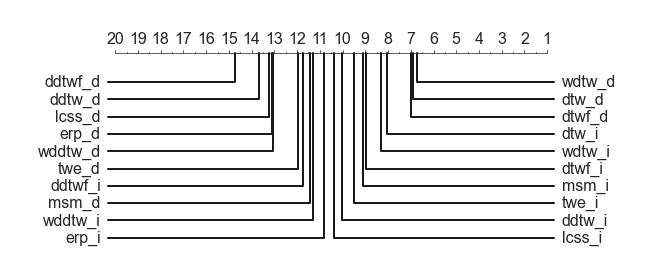

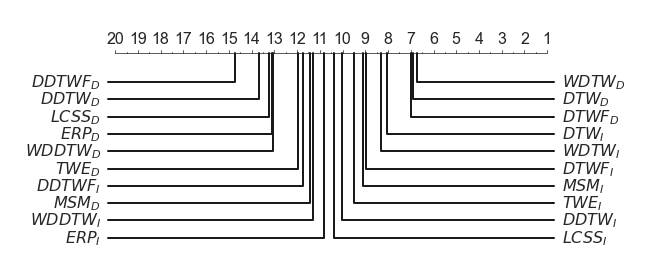

In [267]:
%run "E:/git/dotnet54/TS-CHIEF-DEV/experiments/python/critical_diff"

def cd_mv_measures(type = "all", top = 10, include = [], file_suffix = ""):
    # latex_out = "E:/git/ahmedshifaz/multivariate-elastic-measures/"
    # voting_scheme = 'majority'
    voting_scheme = 'prob'
    # train_test = 'train'
    train_test = 'test'
    config = "i1d2-norm"
    # config = "i1d2+norm"
    # config = "i2d2-norm"
    # config = "i2d2+norm"
    # prod_outdir = f"E:/git/experiments/knn/20-10-2020/sorted/cleaned/{config}/test/"

    prod_outdir = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/"
    latex_out = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/figures/"

    df_perf = pd.read_csv(f"{prod_outdir}/knn-{train_test}-{voting_scheme}-stacked.see.csv",index_col=0)
    cprint(df_perf['classifier'].unique(), 'green')
    df_perf = df_perf[['dataset', 'classifier', 'testAccuracy']]
    df_perf = df_perf.rename(columns={'dataset': 'dataset_name', 'classifier' : 'classifier_name', 'testAccuracy': 'accuracy'})
    print(f"Number of datasets: {len(df_perf['dataset_name'].unique())}")
    print(",".join(df_perf['classifier_name'].unique()))
    display(df_perf.head(5))

    # filter and rename classifiers -- select only group i and d, exclude id and b
    measures = ['dtwf', 'dtwr', 'ddtwf', 'ddtwr', 'wdtw', 'wddtw', 'lcss', 'msm', 'erp', 'twe']
    classifiers = [m + '_i_i' for m in measures] + [m + '_d_d' for m in measures]
    df_perf = df_perf[df_perf['classifier_name'].isin(classifiers + include)]
    cprint(classifiers + include, 'blue')
    cprint(df_perf['classifier_name'].unique(), 'green')
    df_perf['classifier_name'] = df_perf['classifier_name'].apply(lambda x: str(x)[:-2] if x not in include else x)

    df_perf['classifier_name'] = df_perf['classifier_name'].apply(lambda x: x.replace("dtwr", "dtw"))
    df_perf['classifier_name'] = df_perf['classifier_name'].apply(lambda x: x.replace("ddtwr", "ddtw"))

    if type == "top":

        # do a temp ranking with all measures
        p_values, average_ranks, max_nb_datasets = draw_cd_diagram(df_perf=df_perf, save_file = None,
                                                                    zero_method='zsplit', wilcoxon_mode='exact',
                                                                    height_padding = 0.2, show_cliques=False)
        cprint(average_ranks, 'blue')
        cprint(p_values, 'blue')

        # select top k
        filtered_measures = list(average_ranks[-top:].index) + include
        cprint(filtered_measures, 'green')
        df_perf = df_perf[df_perf['classifier_name'].isin(filtered_measures)]
        display(df_perf.head(5))
    elif type == "idep":
        filtered_measures = ['dtwf_i', 'dtw_i', 'ddtwf_i', 'ddtw_i', 'wdtw_i', 'wddtw_i', 'lcss_i', 'erp_i', 'msm_i', 'twe_i'] + include
        df_perf = df_perf[df_perf['classifier_name'].isin(filtered_measures)]
        display(df_perf.head(5))
    elif type == "dep":
        filtered_measures = ['dtwf_d', 'dtw_d', 'ddtwf_d', 'ddtw_d', 'wdtw_d', 'wddtw_d', 'lcss_d', 'erp_d', 'msm_d', 'twe_d'] + include
        df_perf = df_perf[df_perf['classifier_name'].isin(filtered_measures)]
        display(df_perf.head(5))
    else:
        display(df_perf.head(5))
        pass


    # prettify classifier names
    df_perf['classifier_name'] = df_perf['classifier_name'].apply(lambda x: x.replace("ee_", "MEE_"))
    df_perf['classifier_name'] = df_perf['classifier_name'].str.replace('id' , '{id}')
    df_perf['classifier_name'] = '$' + df_perf['classifier_name'].str.upper() + '$'

    # rename MEE_{B}
    df_perf['classifier_name'] = df_perf['classifier_name'].apply(lambda x: x.replace("$MEE_B$", "$MEE_A$ = MEE"))

    filename = f"cd-measures-{voting_scheme}-{train_test}-{config}-{type}{file_suffix}"
    # save dataframe
    df_perf.to_csv(f"{prod_outdir}/figures/{filename}.csv")
    # display(df_perf.head(5))

    # save df
    cprint("="*150, 'red')
    p_values, average_ranks, max_nb_datasets = draw_cd_diagram(df_perf=df_perf, save_file = f"{prod_outdir}/figures/{filename}.pdf", zero_method='zsplit', wilcoxon_mode='exact', height_padding = 0.2, show_cliques=False)
    # p_values, average_ranks, max_nb_datasets = draw_cd_diagram(df_perf=df_perf, save_file = f"{prod_outdir}/figures/{filename}.pdf", zero_method='pratt', wilcoxon_mode='auto', height_padding = 0.2, show_cliques=True)

    # copyfile(filename, latex_out + filename)
    cprint(average_ranks, 'green')
    cprint(p_values, 'green')

    return p_values, average_ranks, max_nb_datasets

# cd_mv_measures(type="top", top=10, include =["ee_i", "ee_d", "ee_id", "ee_b"], file_suffix = "-ee");
# cd_mv_measures(type="top", top=5, include =["ee_b"], file_suffix = "-ee-b");
# cd_mv_measures(type="top", top=10, include =[], file_suffix = "");

# Figures
# cd_mv_measures(type="idep", top=25, include =[], file_suffix = "");
# cd_mv_measures(type="dep", top=25, include =[], file_suffix = "");
# cd_mv_measures(type="idep", top=25, include =["ee_i"], file_suffix = "+mee");
# cd_mv_measures(type="dep", top=25, include =["ee_d"], file_suffix = "+mee");
# cd_mv_measures(type="top", top=9, include =["ee_i", "ee_d", "ee_id", "ee_b"], file_suffix = "+mee");
# cd_mv_measures(type="top", top=5, include =["ee_b"], file_suffix = "+mee_b");
# cd_mv_measures(type="top", top=10, include =[], file_suffix = "");
cd_mv_measures(type="top", top=25, include =[], file_suffix = "-all");


## CD with SOTA

critical_diff.py 10-3-2021.1
['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'Cricket', 'DuckDuckGeese', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'Libras', 'LSST', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'StandWalkJump', 'UWaveGestureLibrary']
Ruiz2021 results over 30 folds, df.shape = (23, 25)


,#,dataset,code,TrainSize,TestSize,Dims,Length,Classes,Default,ROCKET,IT,MUSE,CIF,HC,mrseql,ResNet,DTWA,STC,DTWD,TapNet,gRSF,TSF,CBOSS,RISE,DTWI
0,1,ArticularyWordRecognition,AWR,275,300,9,144,25,0.0400,0.9956,0.9910,0.9887,0.9789,0.9799,0.9898,0.9826,0.9894,0.9751,0.9887,0.9713,0.9821,0.9482,0.9756,0.9573,0.9431
1,2,AtrialFibrillation,AF,15,15,2,640,3,0.3330,0.2489,0.2200,0.7400,0.2511,0.2933,0.3689,0.3622,0.2244,0.3178,0.2356,0.3022,0.2756,0.2978,0.3044,0.2444,0.3467


HC2 paper results over 30 folds, df.shape = (23, 10)


,dataset,HC2,Arsenal,ROCKET,DrCIF,CIF,HC1,TDE,STC,DTW-D
0,ArticularyWordRecognition,0.9958,0.9964,0.9964,0.9788,0.9789,0.9799,0.9773,0.9751,0.9887
1,AtrialFibrillation,0.2822,0.2600,0.2689,0.2333,0.2511,0.2933,0.3022,0.3178,0.2356


MEE results over 10 folds, df.shape = (21, 78)


,Unnamed: 0,dataset,trainsize,testsize,dimensions,length,classes,accuracy,euc_i_i,dtwf_i_i,dtwr_i_i,ddtwf_i_i,ddtwr_i_i,wdtw_i_i,wddtw_i_i,lcss_i_i,msm_i_i,erp_i_i,twe_i_i,euc_d_d,dtwf_d_d,dtwr_d_d,ddtwf_d_d,ddtwr_d_d,wdtw_d_d,wddtw_d_d,lcss_d_d,msm_d_d,erp_d_d,twe_d_d,euc_i_id,euc_d_id,dtwf_i_id,dtwf_d_id,dtwr_i_id,dtwr_d_id,ddtwf_i_id,ddtwf_d_id,ddtwr_i_id,ddtwr_d_id,wdtw_i_id,wdtw_d_id,wddtw_i_id,wddtw_d_id,lcss_i_id,lcss_d_id,msm_i_id,msm_d_id,erp_i_id,erp_d_id,twe_i_id,twe_d_id,euc_d_b,dtwf_d_b,dtwr_i_b,ddtwf_i_b,ddtwr_i_b,wdtw_i_b,wddtw_i_b,lcss_i_b,msm_d_b,erp_i_b,twe_d_b,ee_i,ee_d,ee_id,ee_b,dtwf_i_b,wddtw_d_b,msm_i_b,dtwr_d_b,lcss_d_b,erp_d_b,twe_i_b,wdtw_d_b,euc_i_b,ddtwf_d_b,ddtwr_d_b
0,0,ArticularyWordRecognition,275,300,9,144,25,test,0.9733,0.9800,0.9800,0.6000,0.6900,0.9867,0.6967,0.9933,0.9933,0.9867,0.9833,0.9700,0.9867,0.9833,0.3533,0.3433,0.9867,0.3567,0.9833,0.9833,0.9800,0.9700,0.9733,0.9700,0.9800,0.9867,0.9800,0.9833,0.6000,0.3533,0.6900,0.3433,0.9867,0.9867,0.6967,0.3567,0.9933,0.9833,0.9933,0.9833,0.9867,0.9800,0.9833,0.9700,0.9700,0.9867,0.9800,0.6000,0.6900,0.9867,0.6967,0.9933,0.9833,0.9867,0.9700,0.9867,0.9867,0.9867,0.9900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AtrialFibrillation,15,15,2,640,3,test,0.3333,0.0667,0.2667,0.2000,0.2000,0.2000,0.2000,0.2667,0.3333,0.4667,0.3333,0.3333,0.0667,0.3333,0.1333,0.3333,0.2000,0.2000,0.2667,0.3333,0.3333,0.1333,0.3333,0.3333,0.0667,0.0667,0.2667,0.3333,0.2000,0.1333,0.2000,0.3333,0.2000,0.2000,0.2000,0.2000,0.2667,0.2667,0.3333,0.3333,0.4667,0.3333,0.3333,0.1333,0.3333,NaN,0.1333,0.2000,0.2000,0.2000,NaN,0.2667,NaN,0.4667,0.1333,0.4000,0.3333,0.2667,0.3333,0.0667,0.2000,0.0667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Merged df, df.shape = (21, 8)


,dataset,ROCKET,STC,InceptionTime,HIVE-COTEv2,DrCIF,TDE,$MEE$
0,ArticularyWordRecognition,0.9956,0.9751,0.9910,0.9958,0.9788,0.9773,0.9900
1,AtrialFibrillation,0.2489,0.3178,0.2200,0.2822,0.2333,0.3022,0.3333
2,BasicMotions,0.9900,0.9792,1.0000,0.9892,1.0000,0.9917,0.9750
3,Cricket,1.0000,0.9894,0.9944,0.9995,0.9926,0.9931,1.0000
4,DuckDuckGeese,0.4613,0.4347,0.6347,0.4987,0.5760,0.3220,0.3400


Classifiers:
Index(['$MEE$', 'STC', 'TDE', 'DrCIF', 'InceptionTime', 'ROCKET', 'HIVE-COTEv2'], dtype='object')
Cliques:
[[3, 4, 5, 0, 1, 2], [3, 4, 5, 6]]
Cliques with Names:
[(3, 'DrCIF'), (4, 'InceptionTime'), (5, 'ROCKET'), (0, '$MEE$'), (1, 'STC'), (2, 'TDE')]
[(3, 'DrCIF'), (4, 'InceptionTime'), (5, 'ROCKET'), (6, 'HIVE-COTEv2')]


C:\Users\shifaz\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


21
     classifier_1   classifier_2  p-value  significant
0     HIVE-COTEv2            TDE   0.0004         True
1           $MEE$    HIVE-COTEv2   0.0016         True
2     HIVE-COTEv2            STC   0.0019         True
3           $MEE$         ROCKET   0.0039        False
4          ROCKET            STC   0.0080        False
5          ROCKET            TDE   0.0142        False
6           $MEE$          DrCIF   0.0595        False
7           $MEE$  InceptionTime   0.0595        False
8           DrCIF    HIVE-COTEv2   0.0595        False
9           DrCIF            TDE   0.0701        False
10          $MEE$            TDE   0.0888        False
11          DrCIF            STC   0.0888        False
12  InceptionTime            STC   0.0958        False
13    HIVE-COTEv2         ROCKET   0.1111        False
14          $MEE$            STC   0.1907        False
15  InceptionTime            TDE   0.2428        False
16  InceptionTime         ROCKET   0.2722        False
17    H

<Figure size 432x288 with 0 Axes>

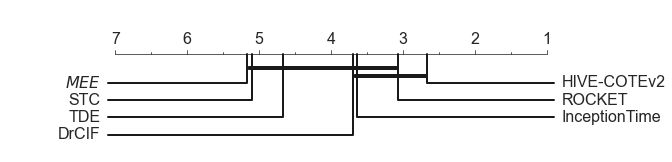

In [166]:
%run "E:/git/dotnet54/TS-CHIEF-DEV/experiments/python/critical_diff"

def cd_mv_sota(type = "all", top = 10, include = [], suffix = ""):
    prod_outdir = "E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/"

    datasets = get_datasets_in_path(f"{prod_outdir}/fold0/")
    print(datasets)

    # LOAD Ruiz2021 results
    ruiz2021 = pd.read_csv("E:/git/dotnet54/jupyter/phd/post-thesis/sota/Ruiz2020-DMKD-18-1-2021.csv")
    ruiz2021 = ruiz2021[ruiz2021['dataset'].isin(datasets)]
    cprint(f"Ruiz2021 results over 30 folds, df.shape = {ruiz2021.shape}", 'blue')
    display(ruiz2021.head(2))
    # removed 'gRSF' 'RISE' 'ResNet', 'CBOSS',, 'CIF'
    # ruiz2021 = ruiz2021[['dataset','ROCKET', 'STC', 'DTWD', 'DTWI', 'IT']]
    ruiz2021 = ruiz2021[['dataset','ROCKET', 'STC', 'IT']]
    # remove nan rows
    if ruiz2021[ruiz2021.isna().any(axis=1)].shape[0] > 0:
        cprint("ERROR: remove NaN columns from data")
        display(ruiz2021[ruiz2021.isna().any(axis=1)])
        return

    # Load HC2 results
    # hc2 = pd.read_csv("E:/git/dotnet54/jupyter/phd/post-thesis/sota/MTSC-SOTA-DefaultTrainTest-withHC2-7-9-2021.csv")
    hc2 = pd.read_csv("E:/git/dotnet54/jupyter/phd/post-thesis/sota/MTSC-SOTA-AverageOver30.csv")
    hc2 = hc2[hc2['dataset'].isin(datasets)]
    cprint(f"HC2 paper results over 30 folds, df.shape = {hc2.shape}" , 'blue')
    display(hc2.head(2))
    hc2 = hc2[['dataset', 'HC2', 'DrCIF', 'TDE']] # removed 'Arsenal'
    # remove nan rows
    if hc2[hc2.isna().any(axis=1)].shape[0] > 0:
        cprint("ERROR: remove NaN columns from data")
        display(hc2[hc2.isna().any(axis=1)])
        return

    # LOAD MEE results
    # mee = pd.read_csv("E:/git/dotnet54/jupyter/phd/post-thesis/sota/knn-test-prob.ee.csv")
    mee = pd.read_csv("E:/git/experiments/knn/20-10-2020/sorted/cleaned/i1d2+norm/test//knn-test-prob.ee.csv")
    # mee = pd.read_csv(f"{prod_outdir}/knn-test-prob.ee.csv")
    # mee = pd.read_csv(f"{prod_outdir}/knn-test-prob-fold0.ee.csv")

    mee = mee[mee['dataset'].isin(datasets)]
    cprint(f"MEE results over 10 folds, df.shape = {mee.shape}" , 'blue')
    display(mee.head(2))
    ## filter columns
    # mee = mee[['dataset', 'ee_b', 'ee_i', 'ee_d', 'ee_id']]
    mee = mee[['dataset', 'ee_b']]
    # mee = mee[['dataset', 'ee_id', 'ee_b']]
    ## remove nan rows
    if mee[mee.isna().any(axis=1)].shape[0] > 0:
        cprint("ERROR: remove NaN columns from data")
        display(mee[mee.isna().any(axis=1)])
        return

    # merge
    df_merged = ruiz2021.merge(hc2, on = 'dataset')
    df_merged = df_merged.merge(mee, on = 'dataset')
    # display(mpf.head(2))

    # prettify names
    df_merged.rename(columns={'HC': 'HIVE-COTEv1'}, inplace=True)
    df_merged.rename(columns={'IT': 'InceptionTime'}, inplace=True)
    df_merged.rename(columns={'DTWI': '$DTW_I$'}, inplace=True)
    df_merged.rename(columns={'DTWD': '$DTW_D$'}, inplace=True)
    df_merged.rename(columns={'HC2': 'HIVE-COTEv2'}, inplace=True)
    #     df_merged.rename(columns={'HC1': 'HIVE-COTEv1'}, inplace=True)
    df_merged.rename(columns={'HC': 'HIVE-COTEv1'}, inplace=True)
    df_merged.rename(columns={'ee_i': '$MEE_I$'}, inplace=True)
    df_merged.rename(columns={'ee_d': '$MEE_D$'}, inplace=True)
    df_merged.rename(columns={'ee_id': '$MEE_{ID}$'}, inplace=True)
    df_merged.rename(columns={'ee_b': '$MEE$'}, inplace=True)


    cprint(f"Merged df, df.shape = {df_merged.shape}" , 'blue')
    display(df_merged.head(5))

    # format data for CD function
    df_cd  = pd.melt(df_merged, id_vars =['dataset'], value_vars =df_merged.columns[1:], value_name = 'accuracy', var_name='classifier_name')
    df_cd = df_cd.rename(columns={"dataset": "dataset_name"})
    # display(df_cd.head())


    filename = f"cd-mee-prob-test-i1d2-norm-sota{suffix}"
    # save dataframe
    df_cd.to_csv(f"{prod_outdir}/figures/{filename}.csv")
    # display(df_perf.head(5))

    # save df
    cprint("="*150, 'red')
    p_values, avg_ranks, n_datasets = draw_cd_diagram(df_perf=df_cd, save_file = f"{prod_outdir}/figures/{filename}.pdf", zero_method='zsplit', wilcoxon_mode='exact', height_padding = 0.2, show_cliques=True)

    print(n_datasets)
    print(p_values)
    print(avg_ranks)
    cprint("-"*150, 'red')
    # display(IFrame(f"{prod_outdir}/figures/{filename}.pdf", 800, 400))

    return p_values, avg_ranks, n_datasets

cd_mv_sota(type="top", top=10, include =[], suffix = "-TEMP");


# Scatter Plots

y shape, (23, 78), x shape (23, 78), df_merged shape(19, 3)
Index(['dataset', 'ee_i_x', 'ee_i_y'], dtype='object')


,dataset,ee_i_x,ee_i_y
1,AtrialFibrillation,0.2000,0.4000
2,BasicMotions,1.0000,0.9750


W/D/L for y-axis = 5/2/12, Total: 19 



C:\Users\shifaz\AppData\Local\Temp/ipykernel_34312/2075742130.py:43: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


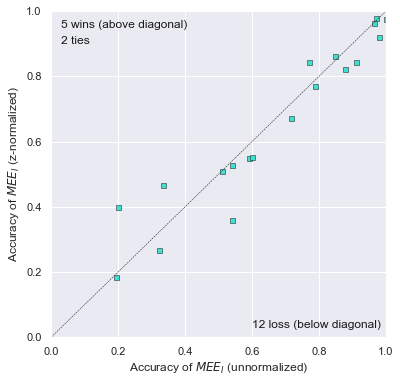

In [265]:
def scatter_norm():


    xdf = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test//knn-test-prob-fold0.ee.csv",index_col=0)
    ydf = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2+norm/test//knn-test-prob-fold0.ee.csv",index_col=0)
    xcol = 'ee_i'
    ycol = 'ee_i'
    xlabel = 'Accuracy of $MEE_I$ (unnormalized)'
    ylabel = 'Accuracy of $MEE_I$ (z-normalized)'

    df_merged = xdf[['dataset', xcol]].merge(ydf[['dataset', ycol]], on='dataset')
    # remove already normalized
    df_merged = df_merged[~df_merged['dataset'].isin(['ArticularyWordRecognition', 'Cricket', 'HandMovementDirection', 'UWaveGestureLibrary'])]
    print(f"y shape, {ydf.shape}, x shape {xdf.shape}, df_merged shape{df_merged.shape}")
    print(df_merged.columns)
    display(df_merged.head(2))
    x = df_merged[xcol + '_x']
    y = df_merged[ycol + '_y']

    fig, ax = plt.subplots(figsize=(6,6))
    sc = ax.scatter(x, y, s=25, lw=0.5, marker = 's', c='turquoise', edgecolor='k')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='k', lw=.5, label='_nolegend_')

    xywins = (x < y).sum()
    xyloss = (x > y).sum()
    xyties = (x == y).sum()
    wdl = f"W/D/L for y-axis = {xywins}/{xyties}/{xyloss}, Total: {len(x)} \n"
    print(wdl)
    #     ax.set_title(wdl)
    xlim = (0.0,1)
    ylim = (0.0,1)
    #     ax.annotate(f"x wins = {xyties}", (xlim[0]+0.7, 0.05), fontsize=12,rotation=0)
    #     ax.annotate(f"draws = {xyties}", (0.03, ylim[1]-0.05-0.05), fontsize=12,rotation=0)
    #     ax.annotate(f"y wins = {xywins}", (0.03, ylim[1]-0.05), fontsize=12,rotation=0)
    ax.annotate(f"{xywins} wins (above diagonal)", (0.03, 0.95), xycoords=ax.transAxes, fontsize=12,rotation=0, color='k')
    ax.annotate(f"{xyties} ties", (0.03, 0.90), xycoords=ax.transAxes, fontsize=12,rotation=0, color='k')
    ax.annotate(f"{xyloss} loss (below diagonal)", (0.60, 0.03), xycoords=ax.transAxes, fontsize=12,rotation=0, color='k')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(f"{xlabel}", fontsize=12)
    ax.set_ylabel(f"{ylabel}", fontsize=12)
    plt.show()
    fig.savefig("E:/git/experiments/knn/10-2-2022/m3//i1d2-norm/test/figures/scatter-mee-i-i1d2-norm-vs-i1d2+norm.pdf", format='pdf', dpi=600, bbox_inches="tight")

scatter_norm()


In [222]:
# temp

def temp_subset_exp():

    # all dims
    df_all_dims = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/test/knn-test-prob.ee.csv")
    df_all_dims = df_all_dims[df_all_dims['dataset'].isin(['BasicMotions', 'Handwriting'])]
    display(df_all_dims[['dataset', 'dtwr_i_i', 'dtwr_d_d']].head())

    cprint('='*200, 'yellow')

    # one dim
    dataset = 'Handwriting'
    for dim in range(0, 3):
        df_dim1 = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/temp/subset/dim{dim}/i1d2-norm/test/fold0/{dataset}/{dataset}-prob.test.ee.csv")
        display(df_dim1[['dataset', 'dtwr_i_i', 'dtwr_d_d']])

    cprint('='*200, 'yellow')

    dataset = 'BasicMotions'
    for dim in range(0, 6):
        df_dim1 = pd.read_csv(f"E:/git/experiments/knn/10-2-2022/m3/i1d2-norm/temp/subset/dim{dim}/i1d2-norm/test/fold0/{dataset}/{dataset}-prob.test.ee.csv")
        display(df_dim1[['dataset', 'dtwr_i_i', 'dtwr_d_d']])

temp_subset_exp()



,dataset,dtwr_i_i,dtwr_d_d
2,BasicMotions,0.9975,0.9600
10,Handwriting,0.4755,0.6111


,dataset,dtwr_i_i,dtwr_d_d
0,Handwriting,0.3153,0.3153


,dataset,dtwr_i_i,dtwr_d_d
0,Handwriting,0.2435,0.2435


,dataset,dtwr_i_i,dtwr_d_d
0,Handwriting,0.3518,0.3518


,dataset,dtwr_i_i,dtwr_d_d
0,BasicMotions,1.0000,1.0000


,dataset,dtwr_i_i,dtwr_d_d
0,BasicMotions,1.0000,1.0000


,dataset,dtwr_i_i,dtwr_d_d
0,BasicMotions,0.9000,0.9000


,dataset,dtwr_i_i,dtwr_d_d
0,BasicMotions,0.9750,0.9750


,dataset,dtwr_i_i,dtwr_d_d
0,BasicMotions,0.8500,0.8500


,dataset,dtwr_i_i,dtwr_d_d
0,BasicMotions,1.0000,1.0000
